# STATS 601: Microenvironment Microarrays
## Team Members: Aaron Abkemeier, Unique Subedi, Victor Verma, Yash Patel

Our analysis is split into the following sections:

- Staining set disparity
- Splotch analysis
- Dimensionality reduction
- Outlier detection
- Significance testing
- Correlation analysis

Each section is annotated with the corresponding code and figures in the sections below along with associated exposition.

## Code Setup
We start simply by loading in the data and organizing properties of subsequent interest.

In [1]:
import copy
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 200)
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import collections
import os
from scipy.ndimage.filters import gaussian_filter
import cv2


/var/folders/4j/yb1phr856mgf1c7fysrq3_6c0000gs/T/ipykernel_16508/2915493213.py:11: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
plates = {f"plate{fn[6:9]}": pd.read_csv(os.path.join("Data", fn), sep = '\t') for fn in os.listdir("Data")}
full_plates = sorted(list(plates.keys()))

num_stain_sets = 3
staining_set_size = 8
staining_sets = [full_plates[staining_set_size * stain_idx:staining_set_size * (stain_idx + 1)] for stain_idx in range(num_stain_sets)]

In [3]:
key_properties_to_cols = {
    "count": "Spot_PA_SpotCellCount",
    "nuclear_area": "Nuclei_CP_AreaShape_Area",
}

def populate_property_minmax(col_name):
    min_prop = np.min([np.min([plates[plate_name][col_name].min() for plate_name in staining_set]) for staining_set in staining_sets])
    max_prop = np.max([np.max([plates[plate_name][col_name].max() for plate_name in staining_set]) for staining_set in staining_sets])
    property_to_min_max[col_name] = (min_prop, max_prop)

property_to_min_max = {}
for key_property in key_properties_to_cols:
    populate_property_minmax(key_properties_to_cols[key_property])

In [4]:
sns.set_style("whitegrid")
plt.rcParams['text.usetex'] = True
plt.rcParams["axes.grid"] = False
blue, = sns.color_palette("muted", 1)

# arghh, got these +1s and -1s floating around cause the data's 1 indexed...
def gen_well_viz_property(plate, well_idx, property):
    well = plate[plate["WellIndex"] == well_idx + 1]
    well_rows, well_cols = 35, 20
    well_heatmap = np.zeros((well_rows, well_cols))
    well_heatmap[well["ArrayRow"] - 1, well["ArrayColumn"] - 1] = well[property].values.reshape(well_heatmap[well["ArrayRow"] - 1, well["ArrayColumn"] - 1].shape)
    return well_heatmap

def viz_well(well_heatmap):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=120)
    sns.heatmap(well_heatmap, ax=ax)
    plt.show()

def viz_plate_property(plate, property, viz_blur=False, fn=None):    
    fig, axs = plt.subplots(2, 4, figsize=(16, 8), dpi=120)
    plt.subplots_adjust(wspace=0, hspace=0)
    cbar_ax = fig.add_axes([.91, .3, .03, .4])

    well_heatmaps = [gen_well_viz_property(plate, well_idx, property) for well_idx in range(8)]
    min_prop, max_prop = property_to_min_max[property]
    well_rows, well_cols = 35, 20

    # for well_idx, well_heatmap in enumerate(well_heatmaps):
    for well_idx, ax in enumerate(axs.flat):
        well_row, well_col = well_idx // 4, well_idx % 4
        ax = axs[well_row, well_col]

        ax.axhline(y=0, color='w',linewidth=3)
        ax.axhline(y=well_rows, color='w',linewidth=3)
        ax.axvline(x=0, color='w',linewidth=3)
        ax.axvline(x=well_cols, color='w',linewidth=3)

        viz_heatmap = well_heatmaps[well_idx]
        if viz_blur:
            viz_heatmap = gaussian_filter(viz_heatmap, sigma=1)

        sns.heatmap(
            viz_heatmap, ax=ax, vmin=min_prop, vmax=max_prop, linewidths=1, 
            linecolor='black', xticklabels=False, yticklabels=False, 
            cbar=(well_idx == 0), cbar_ax=None if well_idx else cbar_ax
        )
    if fn is not None:
        plt.savefig(fn)
    plt.show()

## Staining Set Disparity
### Unnormalized Comparison
We start with basic visualization of the data in the well structure it was collected in. Partitions are drawn for the wells within a given plate. Some observations are revealed through that and visualizing distributions. One is that supposedly equivalent plates across staining sets are *not* distributed evenly in terms of absolute cell counts. We repeat this analysis for nuclear area to demonstrate that such a distributional asymmetry is not an isolated artifact of the cell count. It is worth noting that this analysis reveals not only that the *means* differ across the staining sets, but so too do the distributional spreads. The general shapes, however, are roughly comparable, which is made more apparent in our subsequent analysis of the corresponding normalized quantities.

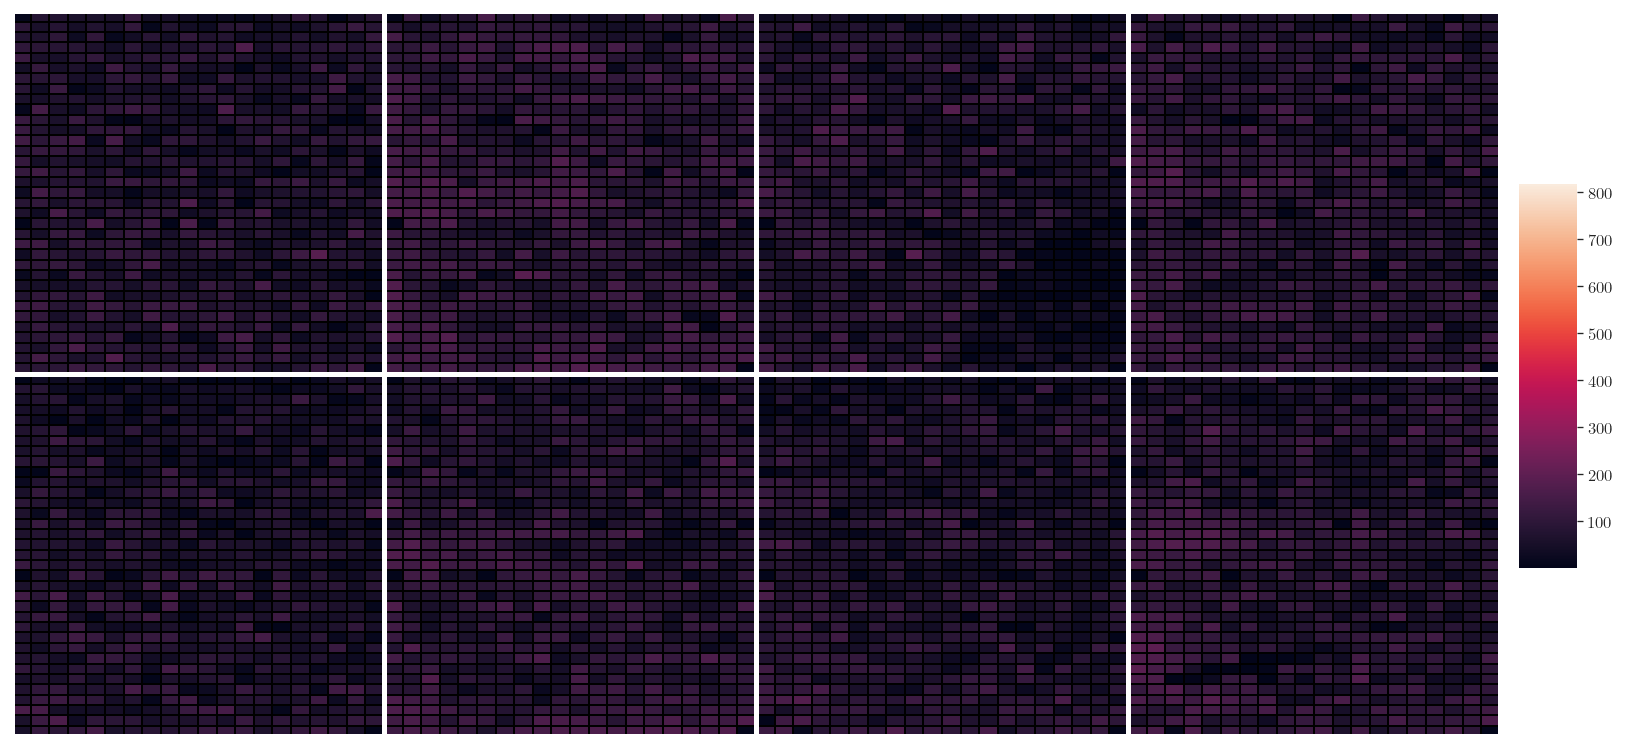

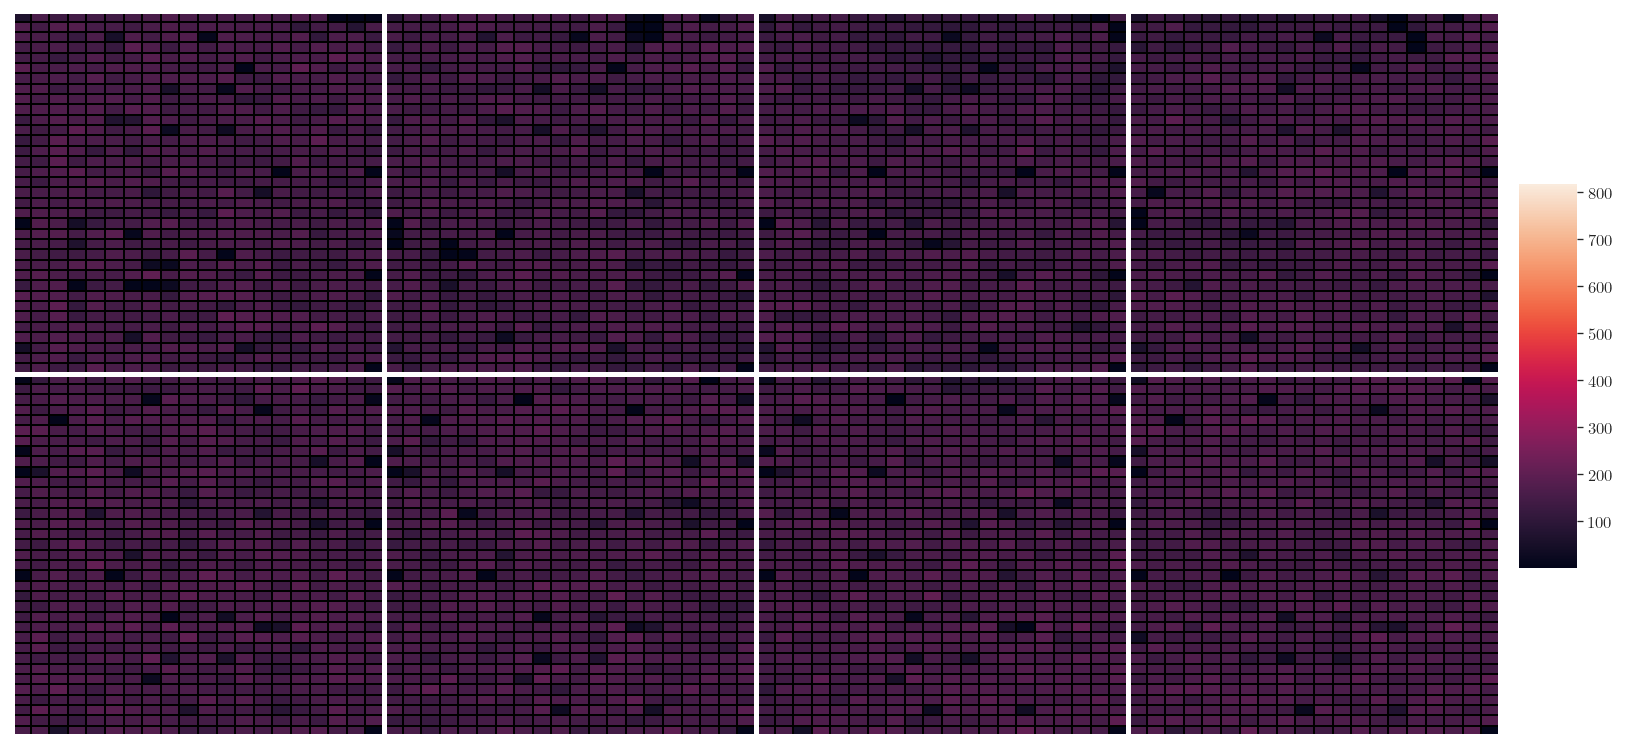

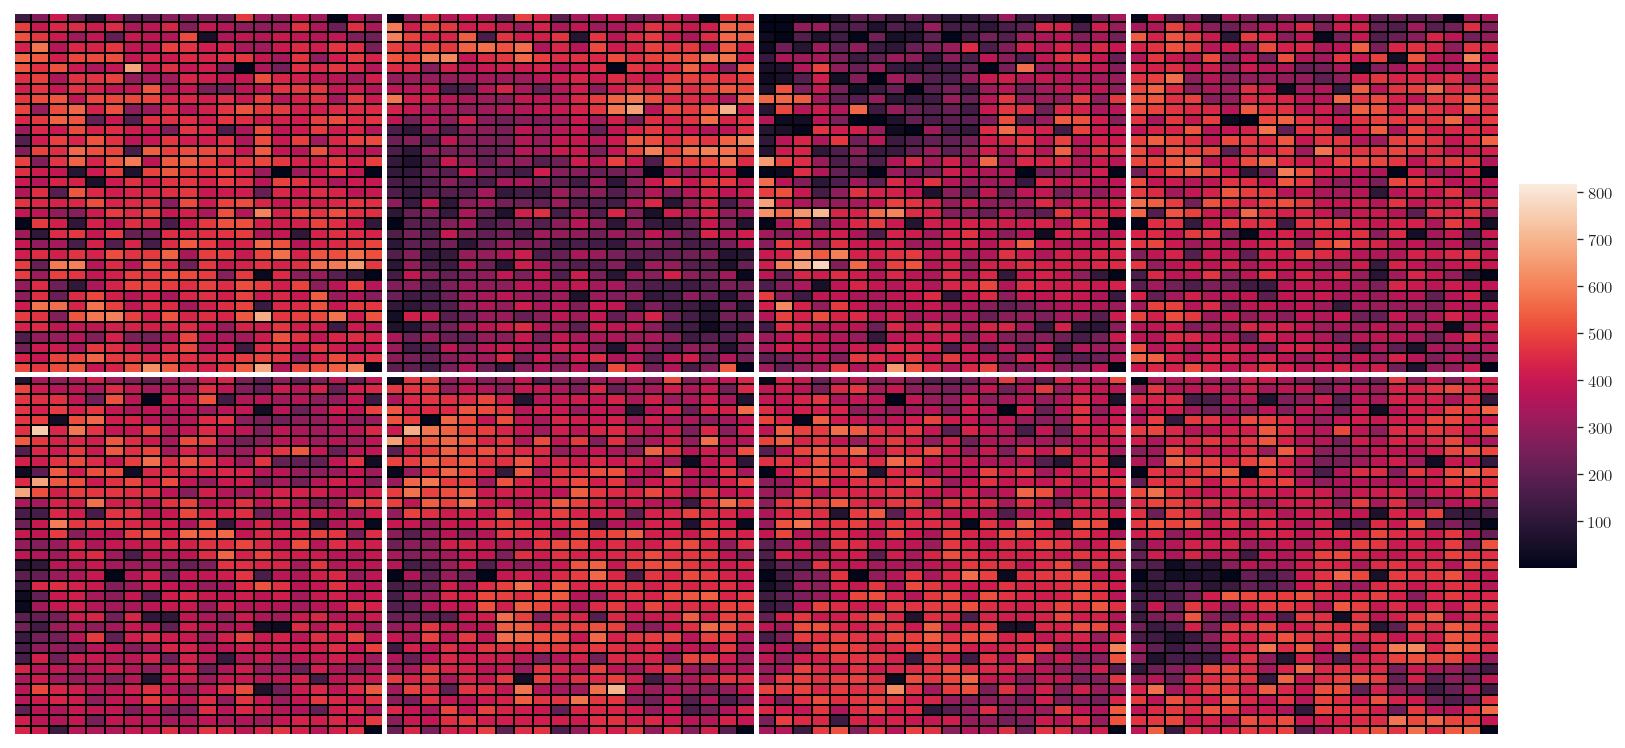

In [5]:
for staining_set_idx, staining_set in enumerate(staining_sets):
    cur_plate = plates[staining_set[3]]
    viz_plate_property(cur_plate, key_properties_to_cols["count"], fn=f"images/unnormed_count_set{staining_set_idx}.png")

/opt/homebrew/Caskroom/miniforge/base/envs/bliss/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/bliss/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/bliss/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code

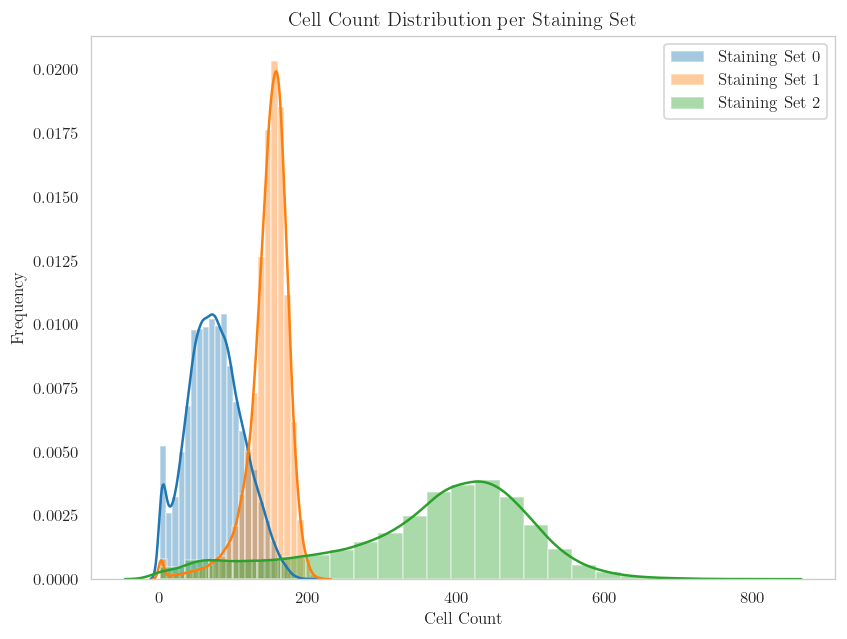

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=120)

for staining_set_idx, staining_set in enumerate(staining_sets):
    staining_set_counts = [plates[plate_name][key_properties_to_cols["count"]] for plate_name in staining_set]
    full_counts = np.concatenate(staining_set_counts)
    sns.distplot(full_counts, bins=25, label=r"$\mathrm{Staining \ Set \ " + str(staining_set_idx) + r"}$")

plt.title(r"$\mathrm{Cell \ Count \ Distribution \ per \ Staining \ Set}$")
plt.xlabel(r"$\mathrm{Cell \ Count}$")
plt.ylabel(r"$\mathrm{Frequency}$")

plt.legend()
plt.savefig("images/unnormed_count_dist.png", bbox_inches='tight')

As mentioned above, repeating this analysis for the nuclear area reveals a similar disparity across staining sets:

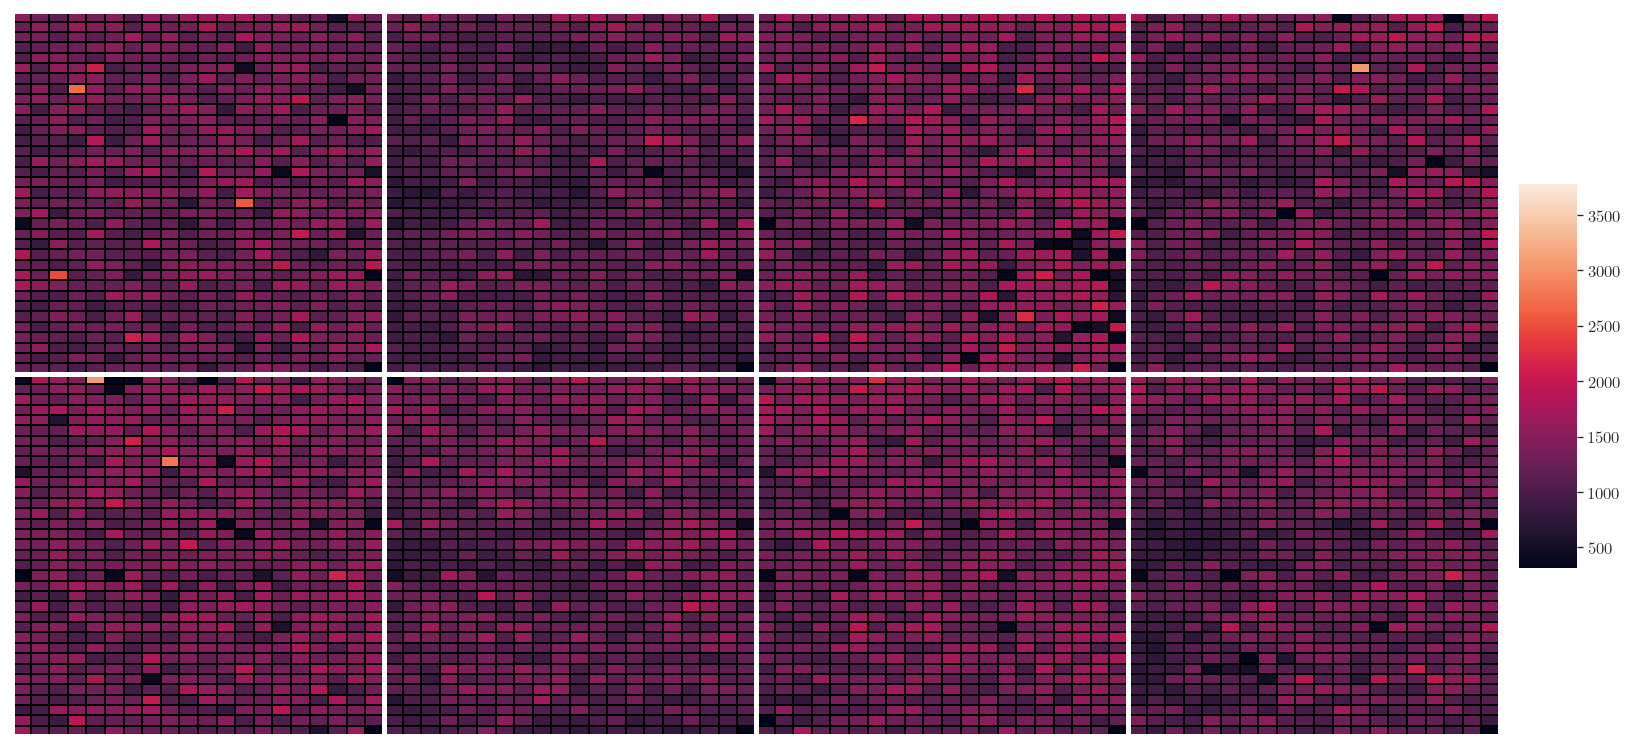

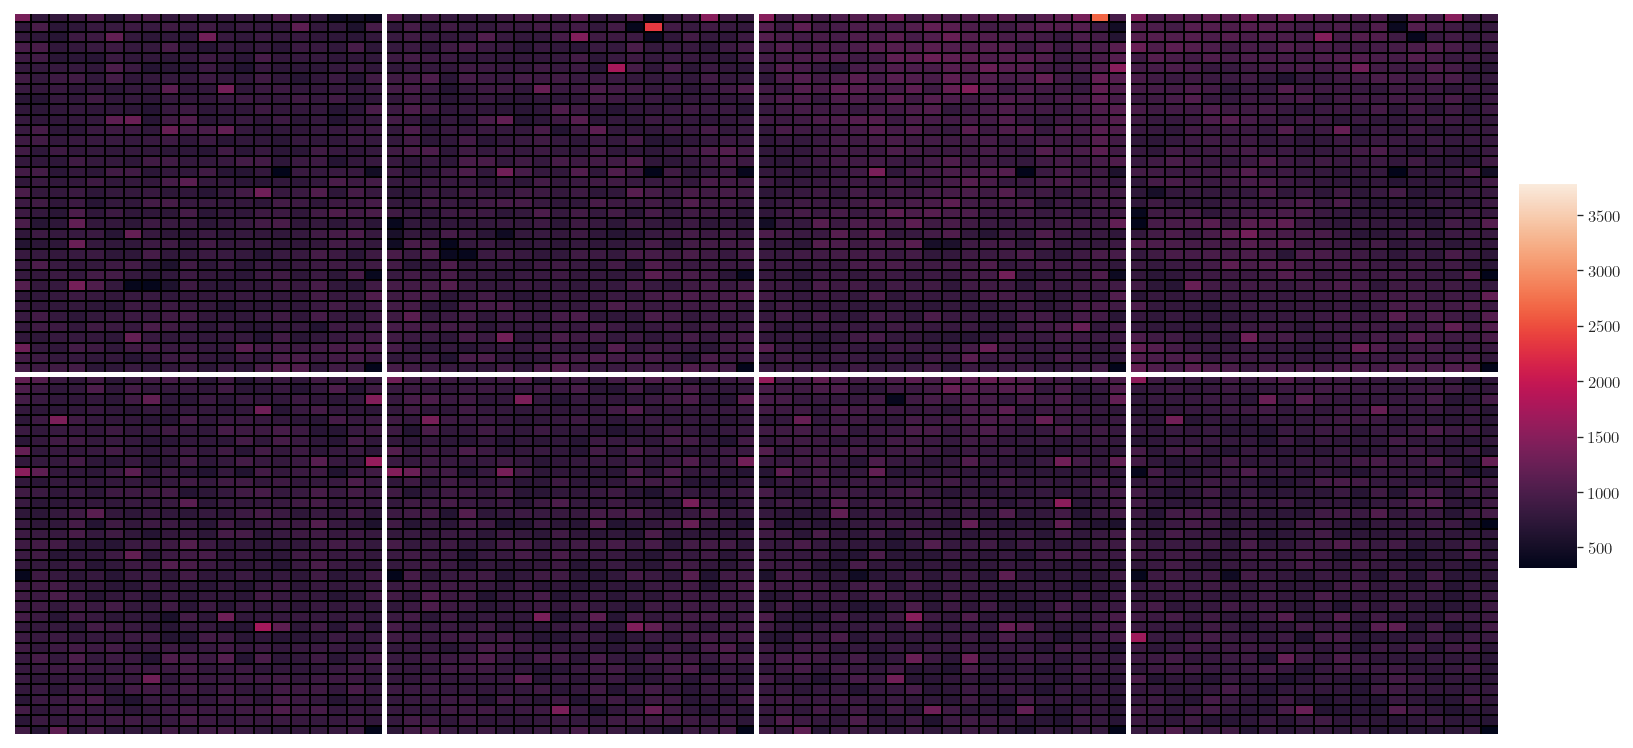

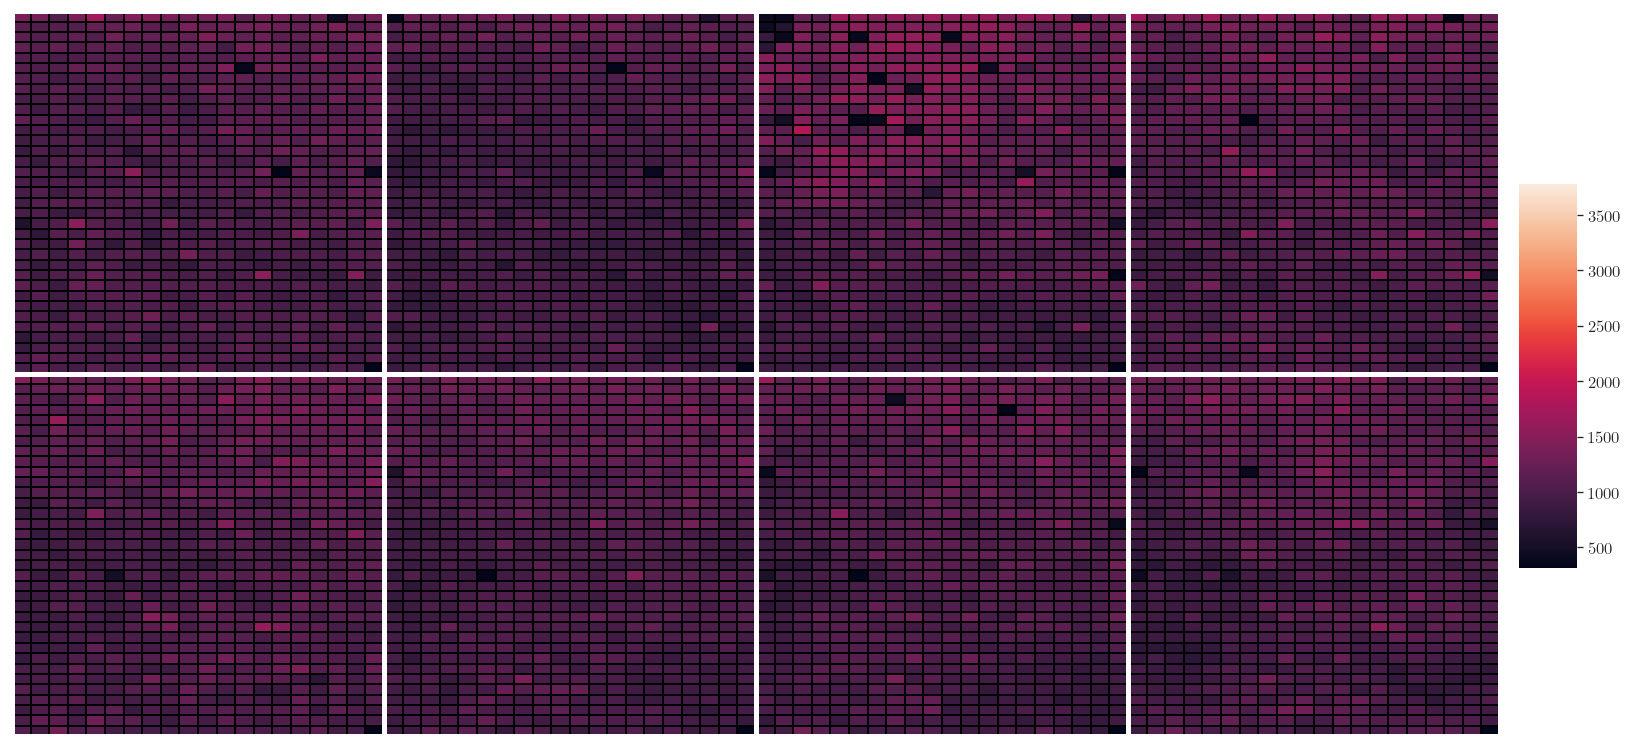

In [7]:
for staining_set_idx, staining_set in enumerate(staining_sets):
    cur_plate = plates[staining_set[3]]
    viz_plate_property(cur_plate, key_properties_to_cols["nuclear_area"], fn=f"images/unnormed_nuclear_area_set{staining_set_idx}.png")

/opt/homebrew/Caskroom/miniforge/base/envs/bliss/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/bliss/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/bliss/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code

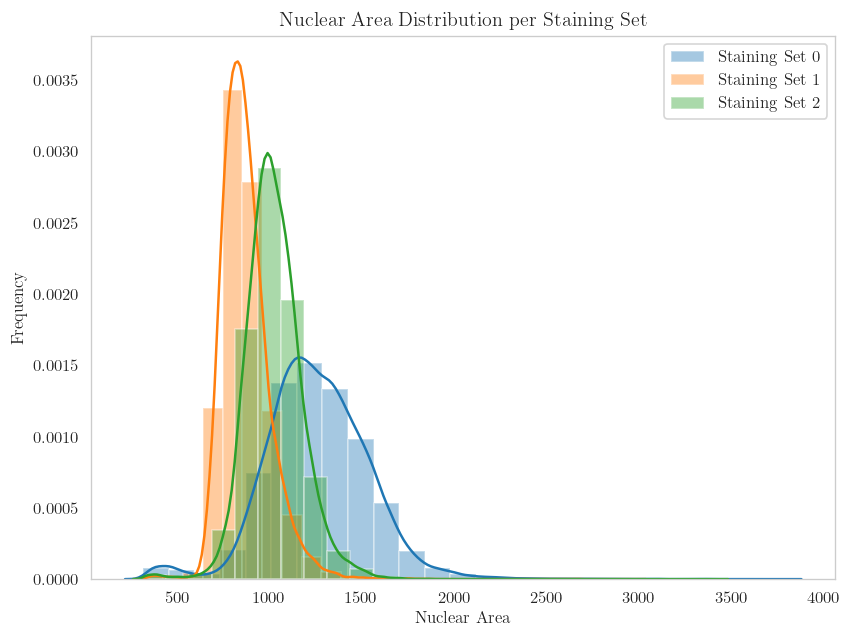

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=120)

for staining_set_idx, staining_set in enumerate(staining_sets):
    staining_set_counts = [plates[plate_name][key_properties_to_cols["nuclear_area"]] for plate_name in staining_set]
    full_counts = np.concatenate(staining_set_counts)
    sns.distplot(full_counts, bins=25, label=r"$\mathrm{Staining \ Set \ " + str(staining_set_idx) + r"}$")

plt.title(r"$\mathrm{Nuclear \ Area \ Distribution \ per \ Staining \ Set}$")
plt.xlabel(r"$\mathrm{Nuclear \ Area}$")
plt.ylabel(r"$\mathrm{Frequency}$")

plt.legend()
plt.savefig("images/unnormed_nuclear_area_dist.png", bbox_inches='tight')

### Normalized Comparison
We observe that normalizing the data improves alignment of the distributions, both from visual inspection of the data and looking at the corresponding distribution plots. The normalization factors $\overline{x}, \sigma_x$ are computed *per* staining set. That is, for each staining set, the mean and standard deviation were computed and shared for normalization across all wells in that staining set:

$$ \widehat{x} \gets \frac{x - \overline{x}}{\sigma_x} $$ 

In [9]:
for staining_set in staining_sets:
    staining_set_counts = [plates[plate_name][key_properties_to_cols["count"]] for plate_name in staining_set]
    full_counts = np.concatenate(staining_set_counts)
    full_mean = np.mean(full_counts)
    full_std = np.std(full_counts)
    
    for plate_name in staining_set:
        plates[plate_name]["std_count"] = (plates[plate_name][key_properties_to_cols["count"]] - full_mean) / full_std
populate_property_minmax("std_count")

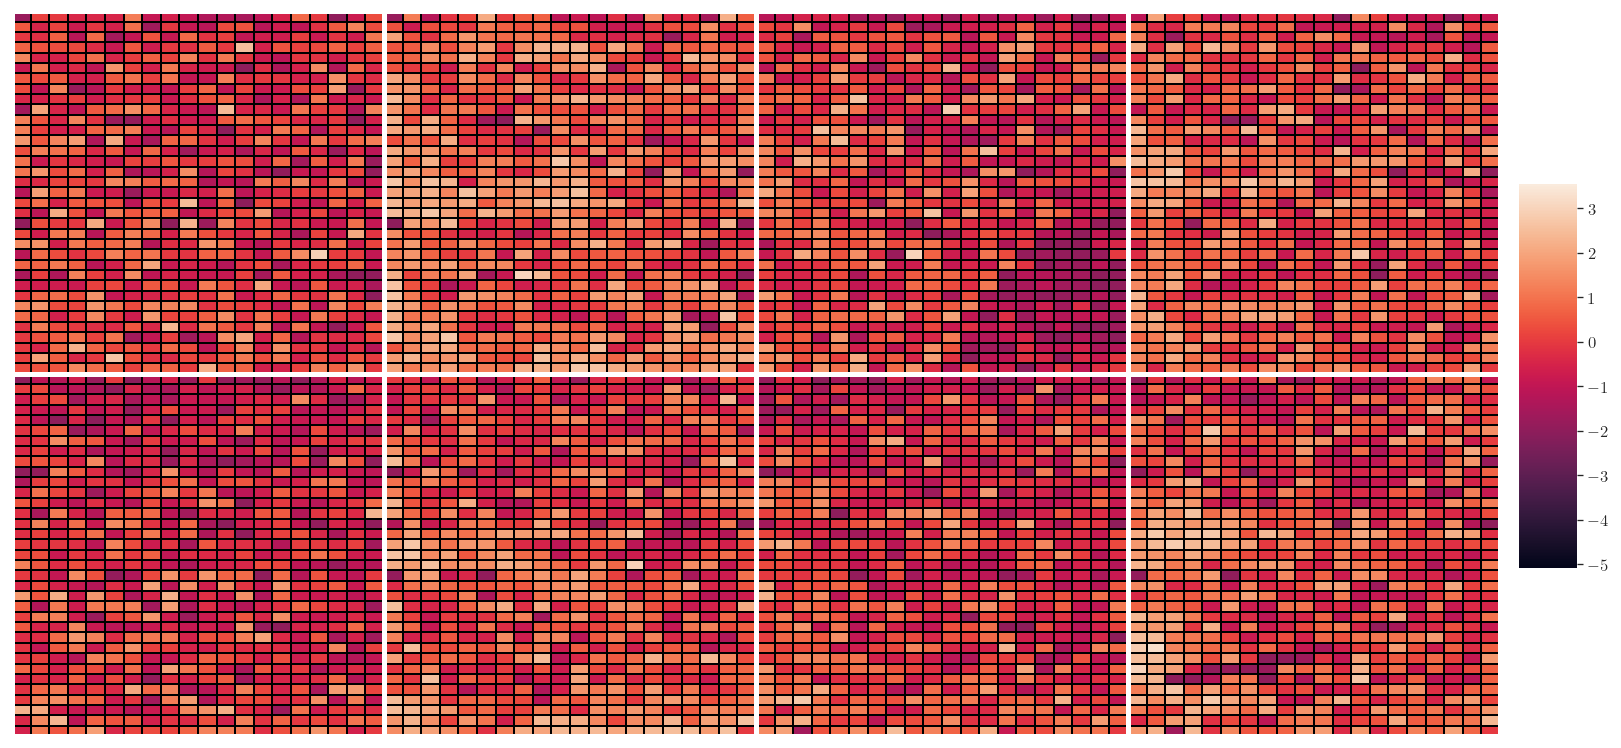

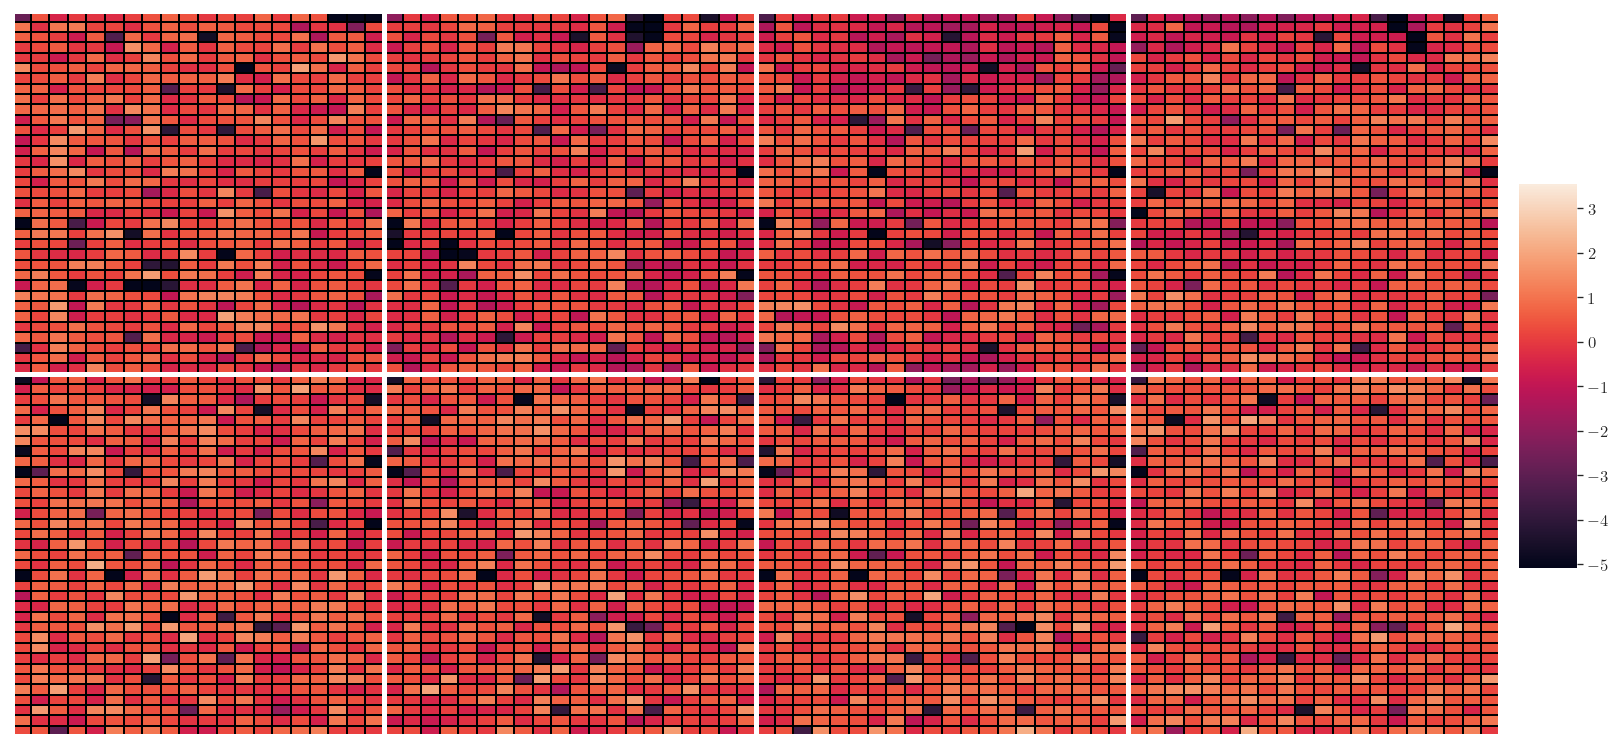

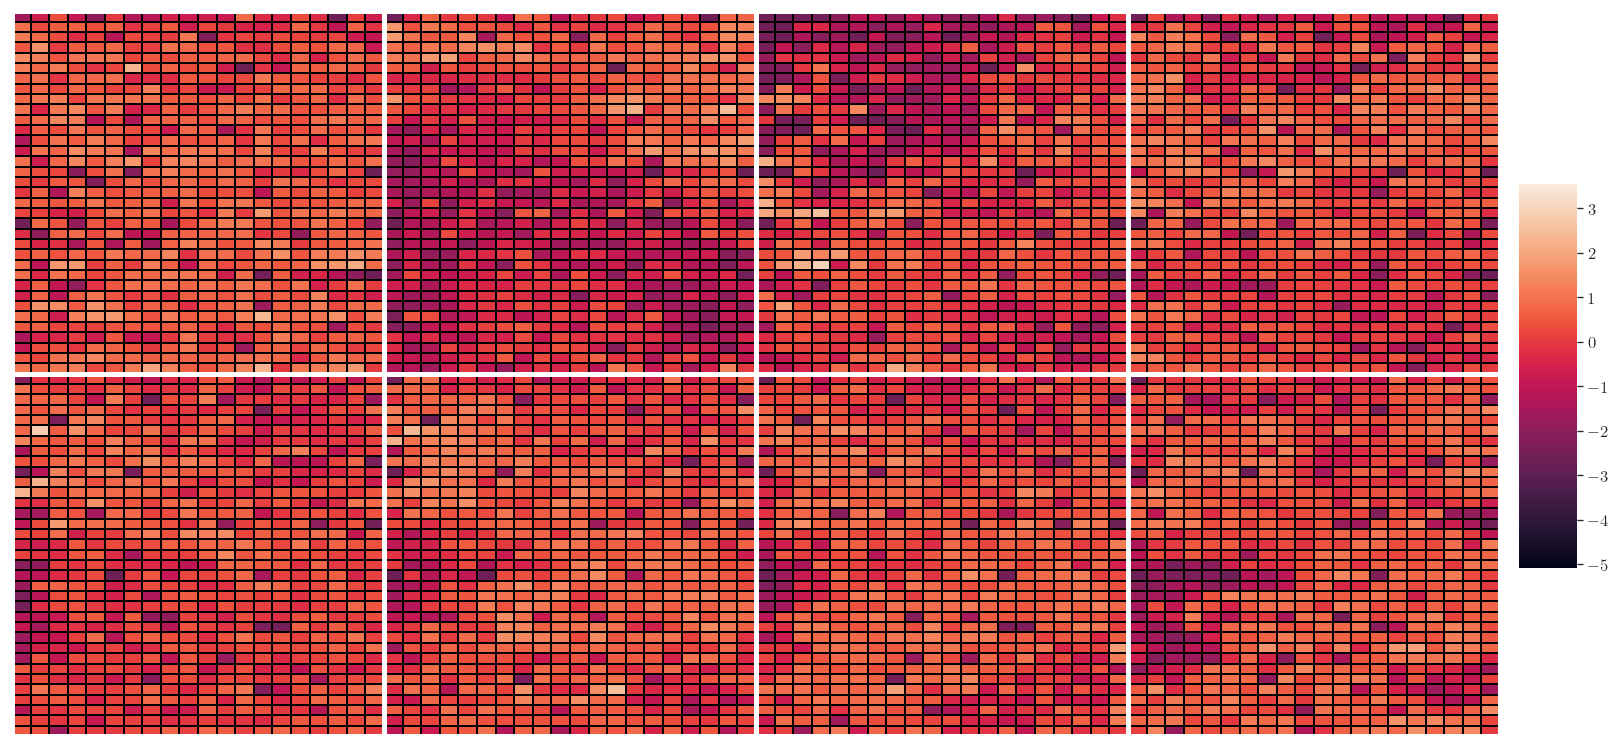

In [10]:
for staining_set_idx, staining_set in enumerate(staining_sets):
    cur_plate = plates[staining_set[3]]
    viz_plate_property(cur_plate, "std_count", fn=f"images/normed_count_set{staining_set_idx}.png")

/opt/homebrew/Caskroom/miniforge/base/envs/bliss/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/bliss/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/bliss/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code

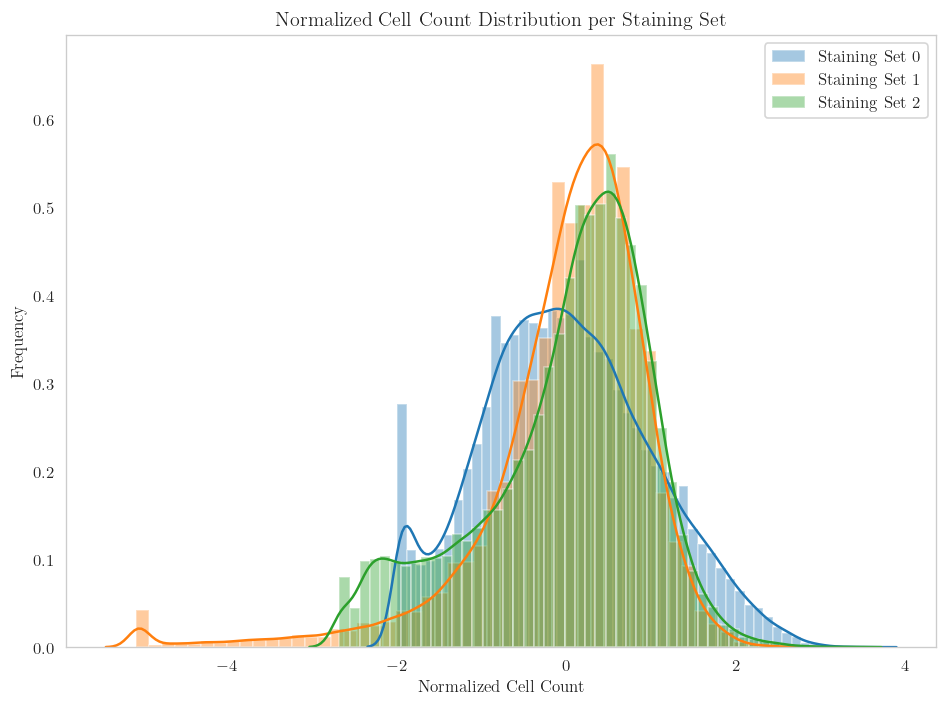

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=120)

for staining_set_idx, staining_set in enumerate(staining_sets):
    staining_set_counts = [plates[plate_name]["std_count"] for plate_name in staining_set]
    full_counts = np.concatenate(staining_set_counts)
    sns.distplot(full_counts, label=r"$\mathrm{Staining \ Set \ " + str(staining_set_idx) + r"}$")

plt.title(r"$\mathrm{Normalized \ Cell \ Count \ Distribution \ per \ Staining \ Set}$")
plt.xlabel(r"$\mathrm{Normalized \ Cell \ Count}$")
plt.ylabel(r"$\mathrm{Frequency}$")

plt.legend()
plt.tight_layout()
plt.savefig("images/normed_count_dist.png", bbox_inches='tight')

Once again repeating this normalization for the nuclear area, we see a similar result emerge.

In [12]:
for staining_set in staining_sets:
    staining_set_counts = [plates[plate_name][key_properties_to_cols["nuclear_area"]] for plate_name in staining_set]
    full_counts = np.concatenate(staining_set_counts)
    full_mean = np.mean(full_counts)
    full_std = np.std(full_counts)
    
    for plate_name in staining_set:
        plates[plate_name]["std_nuclear_area"] = (plates[plate_name][key_properties_to_cols["nuclear_area"]] - full_mean) / full_std
populate_property_minmax("std_nuclear_area")

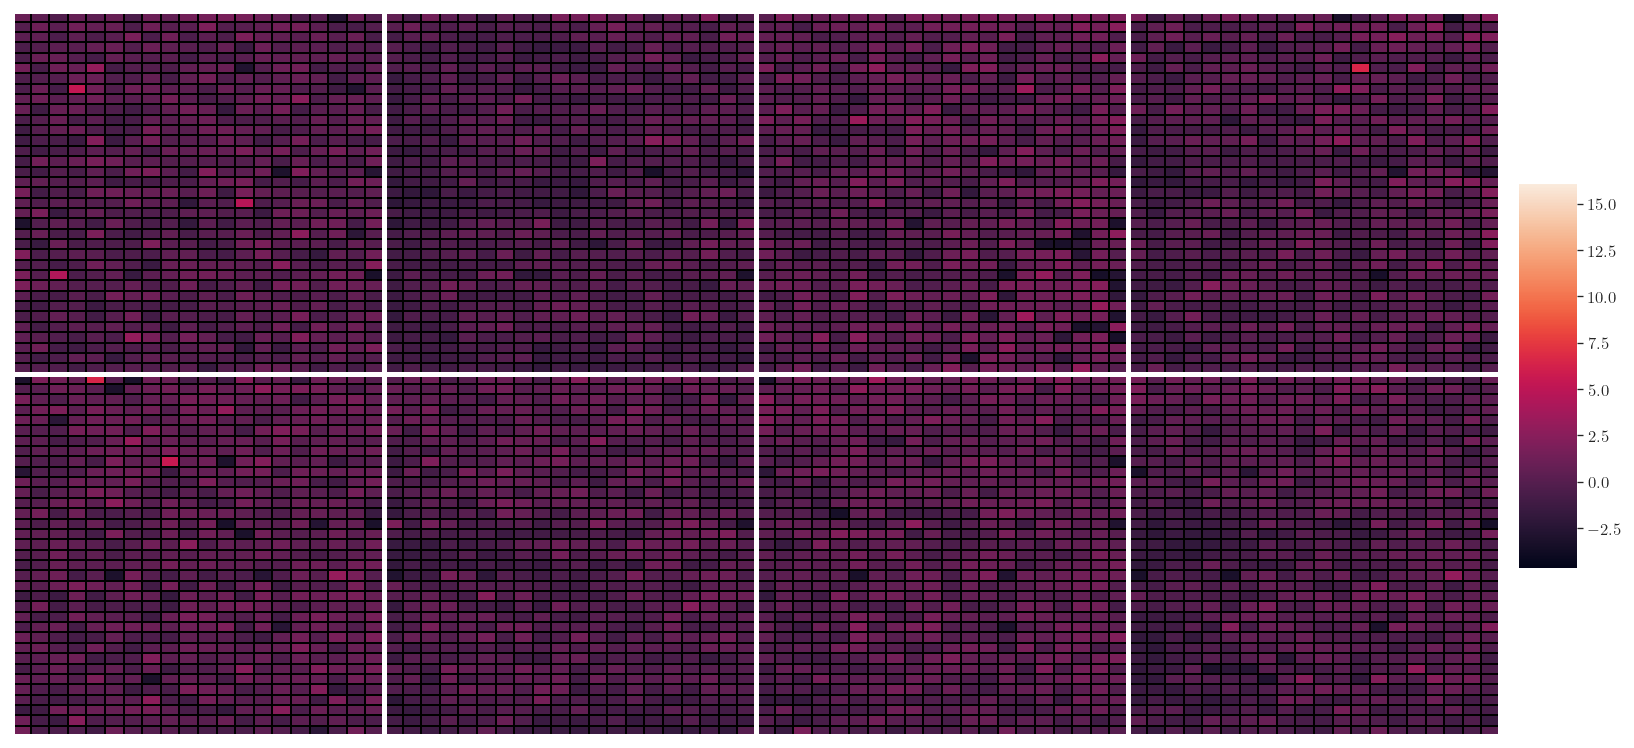

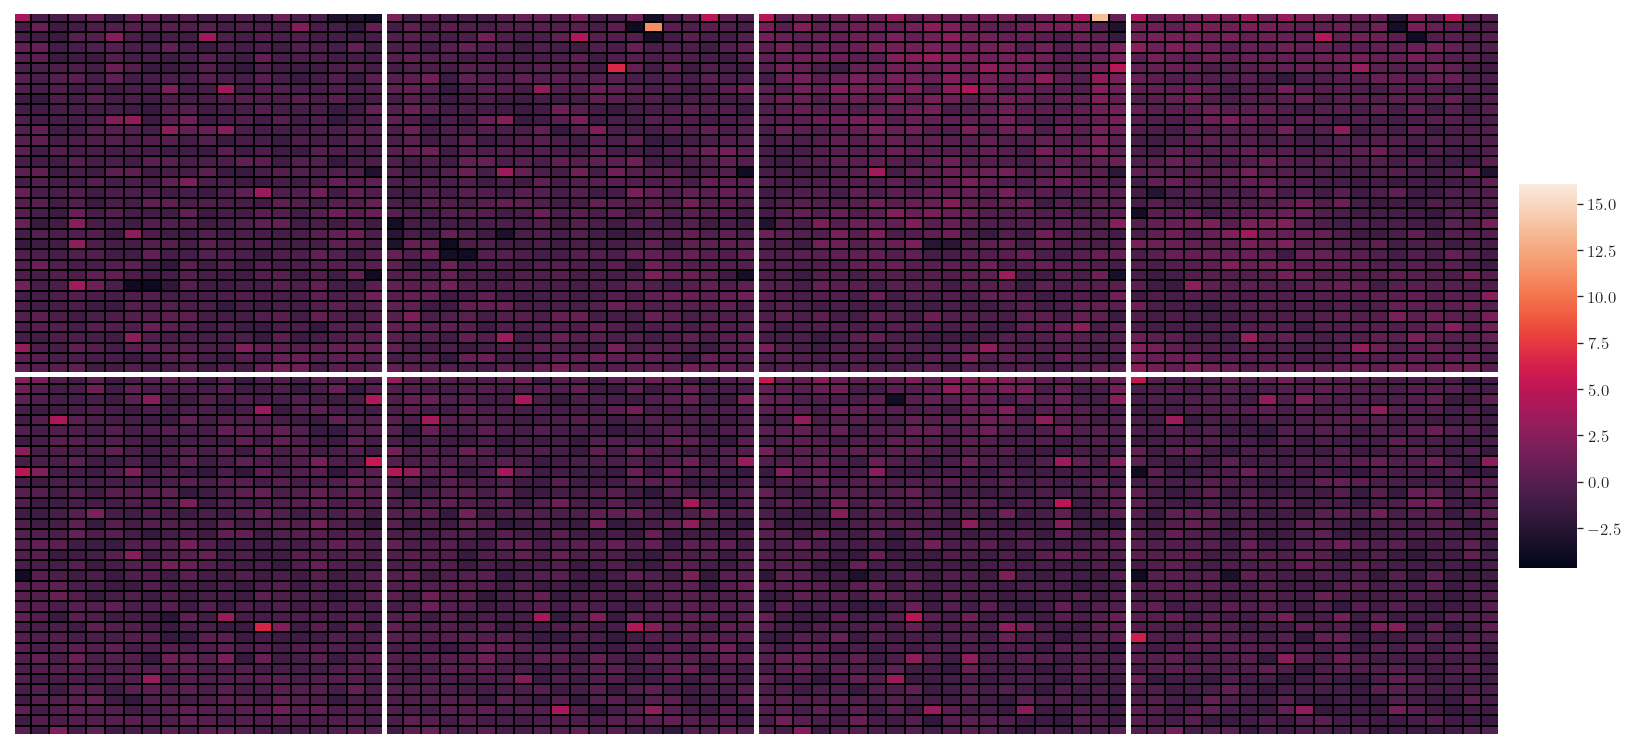

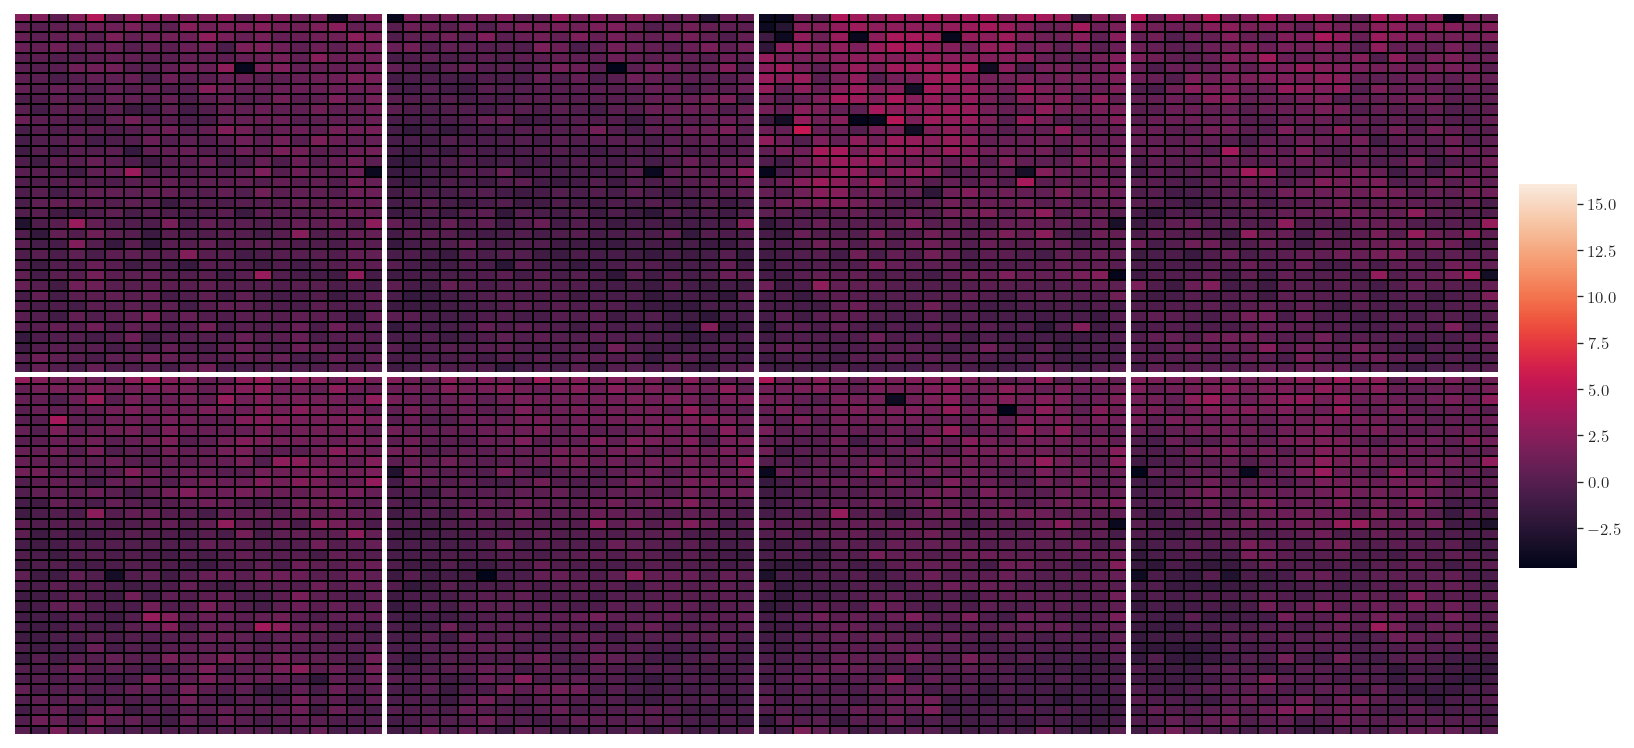

In [13]:
for staining_set_idx, staining_set in enumerate(staining_sets):
    cur_plate = plates[staining_set[3]]
    viz_plate_property(cur_plate, "std_nuclear_area", fn=f"images/normed_nuclear_area_set{staining_set_idx}.png")

/opt/homebrew/Caskroom/miniforge/base/envs/bliss/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/bliss/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/bliss/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code

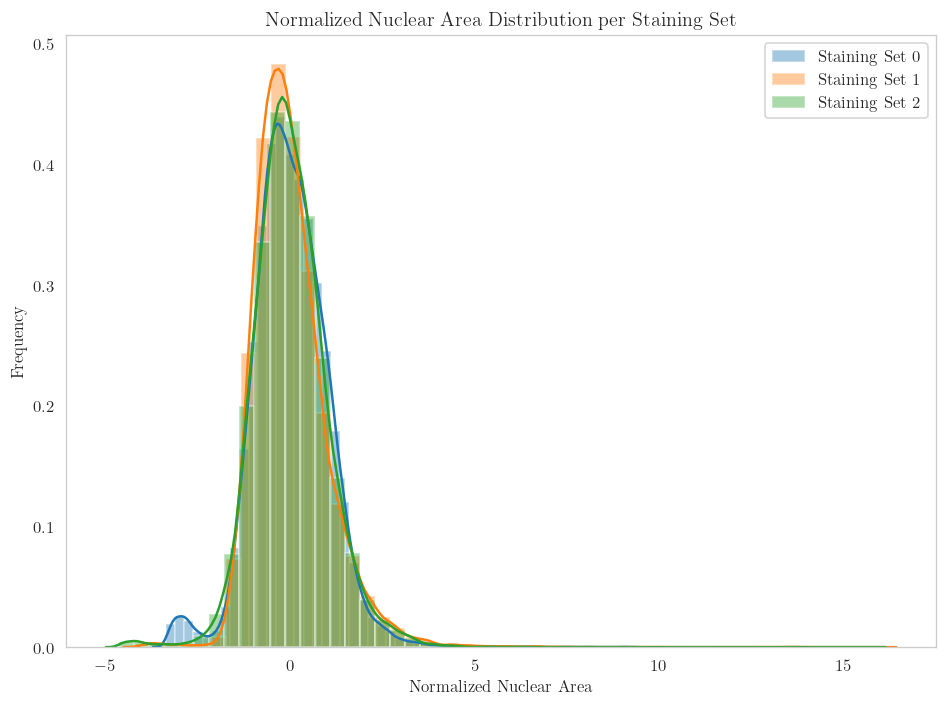

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=120)

for staining_set_idx, staining_set in enumerate(staining_sets):
    staining_set_counts = [plates[plate_name]["std_nuclear_area"] for plate_name in staining_set]
    full_counts = np.concatenate(staining_set_counts)
    sns.distplot(full_counts, label=r"$\mathrm{Staining \ Set \ " + str(staining_set_idx) + r"}$")

plt.title(r"$\mathrm{Normalized \ Nuclear \ Area \ Distribution \ per \ Staining \ Set}$")
plt.xlabel(r"$\mathrm{Normalized \ Nuclear \ Area}$")
plt.ylabel(r"$\mathrm{Frequency}$")

plt.legend()
plt.tight_layout()
plt.savefig("images/normed_nuclear_area_dist.png", bbox_inches='tight')

### Staining Set Disparity Takeaway
Observing the distributional disparities between these staining sets, we recommend analysis be conducted *separately* per staining set. If, however, it is of interest to combine staining sets for shared features, such as the cell count and nuclear area described above, we recommend the you normalize the data features prior to combining them, which serves to align the corresponding empirical distributions well.

## Splotch Analysis
Similarly, visualizing the plates across the staining sets reveals strong spatial structure, once again unexpected coming into the analysis. Given the randomization of ECMP locations per plate, we would not expect any spatial coherence of the data, with the most likely source being an external factor introduced through experimental error. To visualize this, we use the properties normalized *per well* and run a connected components analysis on regions with values $< -1.0$ in this normalized space. "Connected components" here refers to finding contiguous pixels (defined to be pixels that are either horizontally, vertically, or diagonally connected) and only keeping those components of sufficiently large area (taken to be 5 here). This allows us to find *regions* of the image that have lower cell count/area rather than individual spots, which may have lower cell count/area for completely valid experimental reasons (i.e. due to interactions with the ligand/ECMP). That is, we wish to just inspect the regions we believe to be due to experimental error.

We begin by illustrating this phenomenon on the cell counts.

In [20]:
def connected_components_analysis(property_name):
    heatmap_mask = None

    for staining_set_idx, staining_set in enumerate(staining_sets):
        for plate_name in staining_set:
            fig, axs = plt.subplots(2, 4, figsize=(16, 8), dpi=120)
            plt.subplots_adjust(wspace=0, hspace=0)
            
            for well_idx in range(8):
                plate = plates[plate_name]
                # well_std_count = gen_well_viz_property(plate, well_idx, [key_properties_to_cols["count"]])
                well_count = gen_well_viz_property(plate, well_idx, [key_properties_to_cols[property_name]])
                well_std_count = (well_count - np.mean(well_count)) / np.std(well_count)
                thresh = (well_std_count < -1.5).astype(np.int8)
                output = cv2.connectedComponentsWithStats(thresh, 4, cv2.CV_32S)
                (numLabels, labels, stats, centroids) = output
                mask = np.zeros(thresh.shape, dtype="uint8")

                # loop over the number of unique connected component labels, skipping
                # over the first label (label zero is the background)
                for i in range(1, numLabels):
                    x = stats[i, cv2.CC_STAT_LEFT]
                    y = stats[i, cv2.CC_STAT_TOP]
                    w = stats[i, cv2.CC_STAT_WIDTH]
                    h = stats[i, cv2.CC_STAT_HEIGHT]
                    area = stats[i, cv2.CC_STAT_AREA]

                    if area > 5:
                        componentMask = (labels == i).astype("uint8") * 255
                        mask = cv2.bitwise_or(mask, componentMask)

                well_rows, well_cols = 35, 20
                ax = axs[well_idx // 4, well_idx % 4]
                ax.axhline(y=0, color='w',linewidth=3)
                ax.axhline(y=well_rows, color='w',linewidth=3)
                ax.axvline(x=0, color='w',linewidth=3)
                ax.axvline(x=well_cols, color='w',linewidth=3)
                
                sns.heatmap(
                    mask, ax=ax, linewidths=1, 
                    cbar=False, cbar_ax=None, vmin=0, vmax=1,
                    linecolor='black', xticklabels=False, yticklabels=False, 
                )
                if heatmap_mask is None:
                    heatmap_mask = copy.deepcopy(mask)
                else:
                    heatmap_mask += (mask // 255)

            if staining_set_idx == 2:
                plt.savefig(f"images/segmentation/{plate_name}.png", bbox_inches='tight')
                plt.show()
            plt.clf()
    return heatmap_mask

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

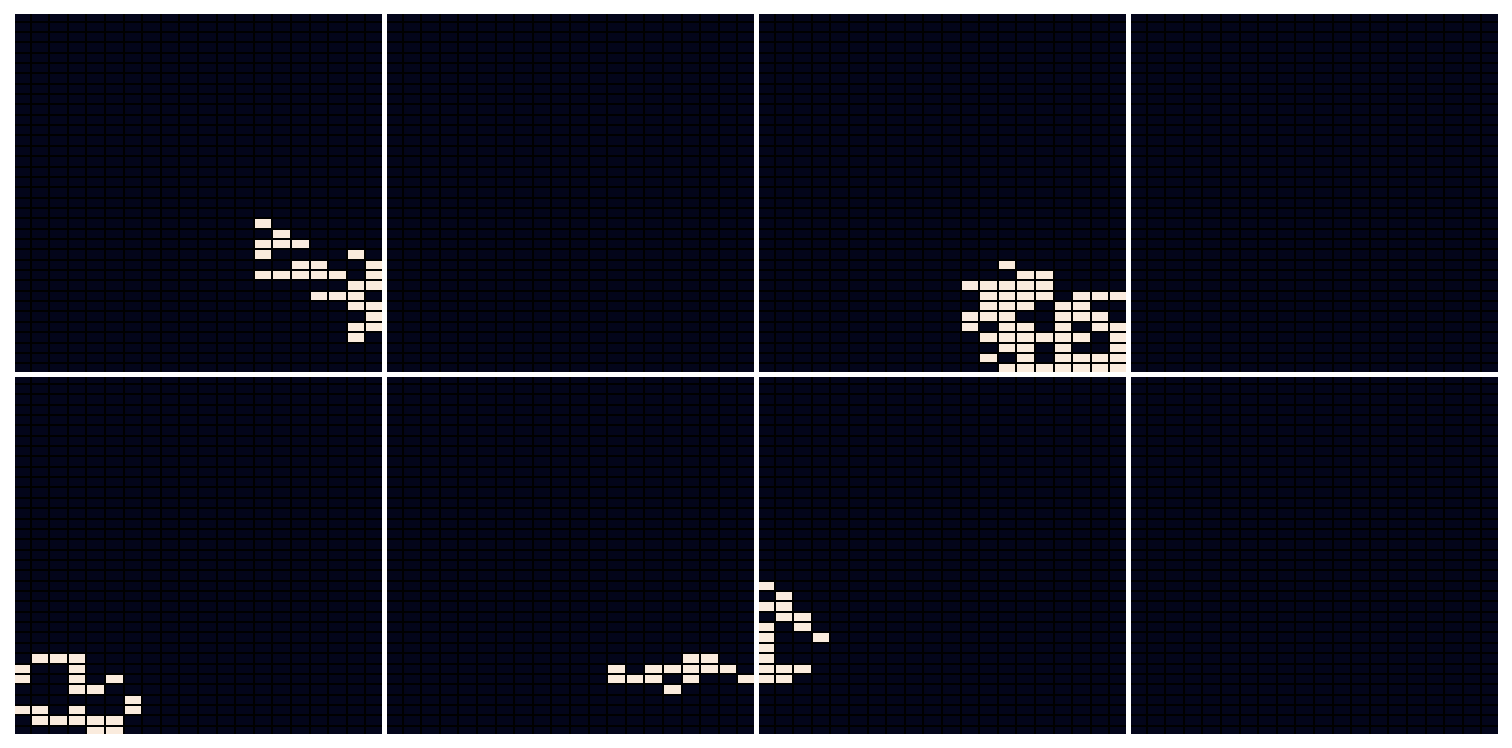

<Figure size 432x288 with 0 Axes>

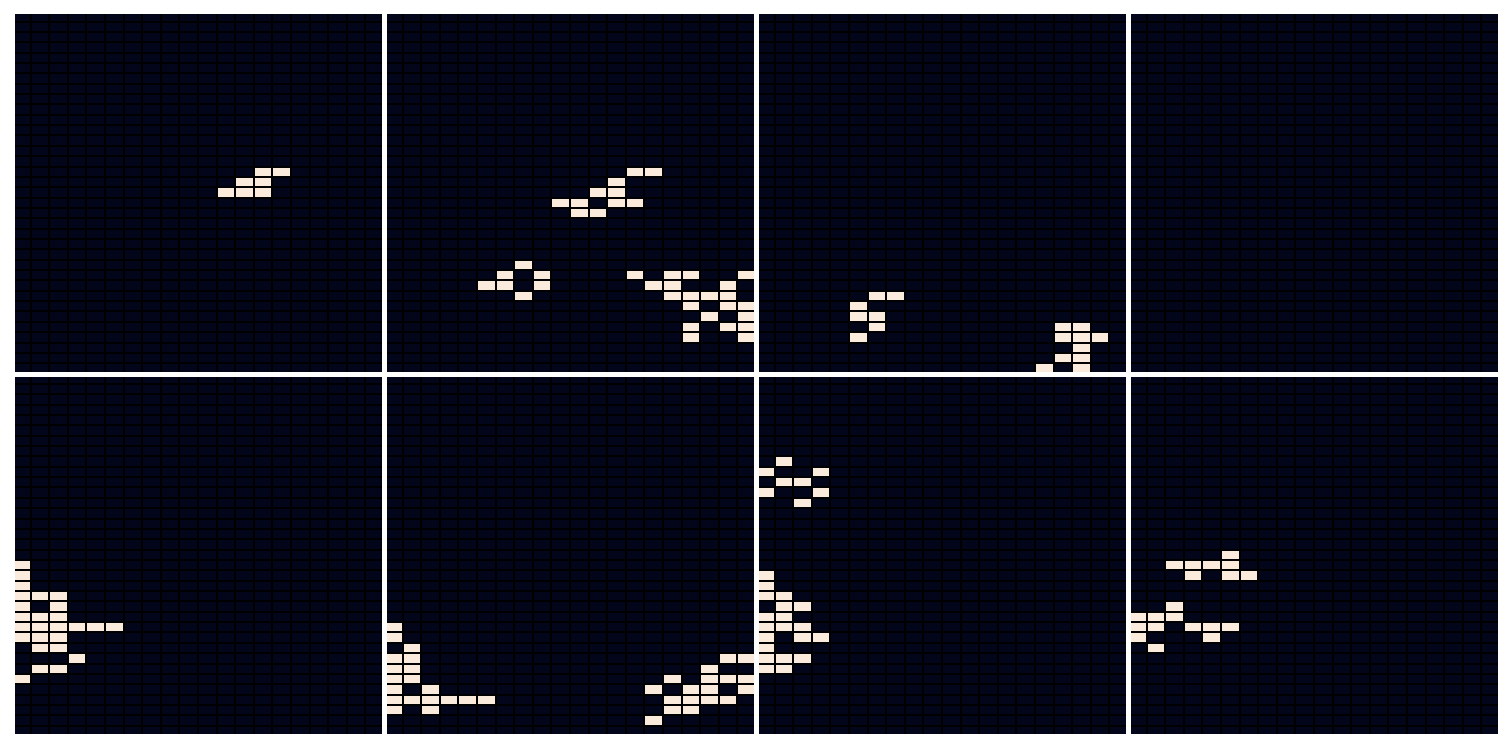

<Figure size 432x288 with 0 Axes>

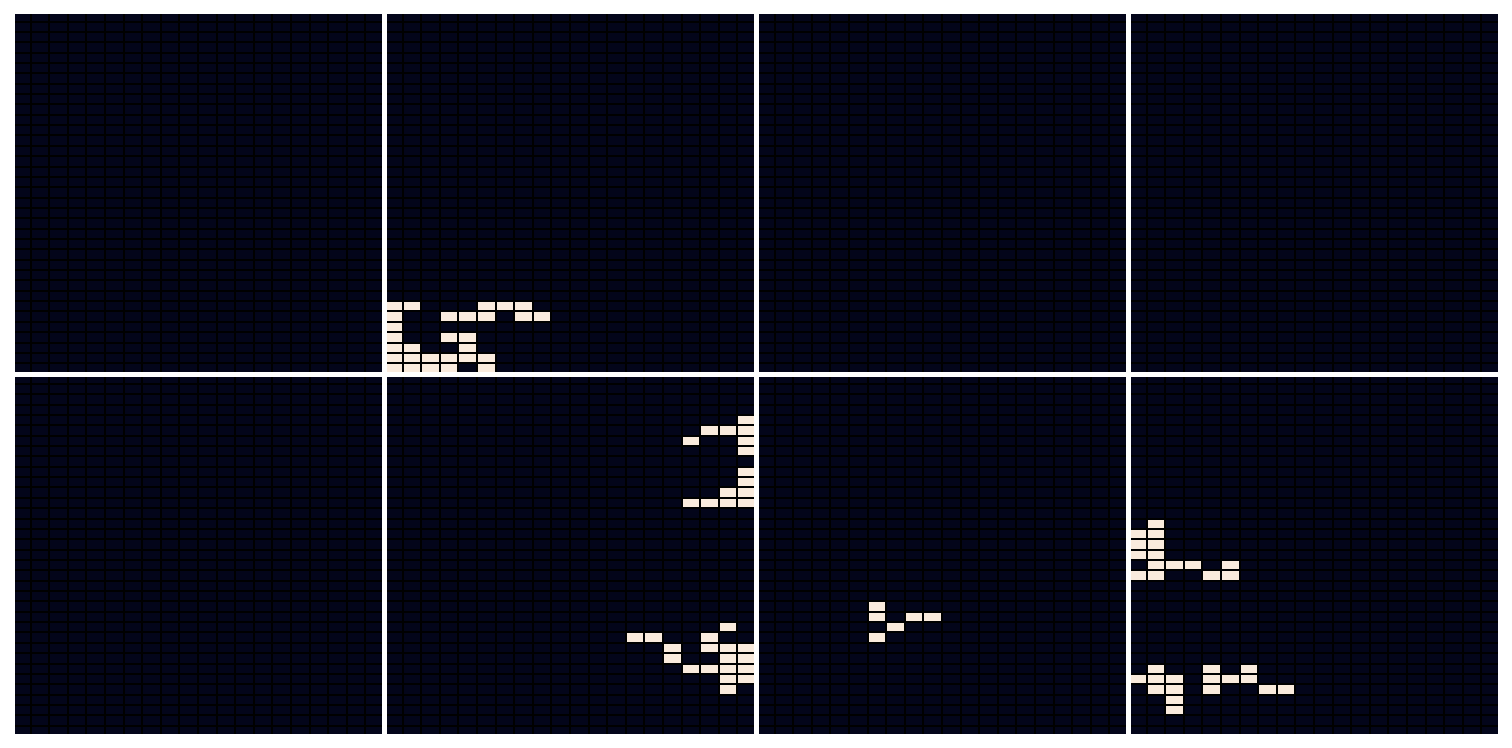

<Figure size 432x288 with 0 Axes>

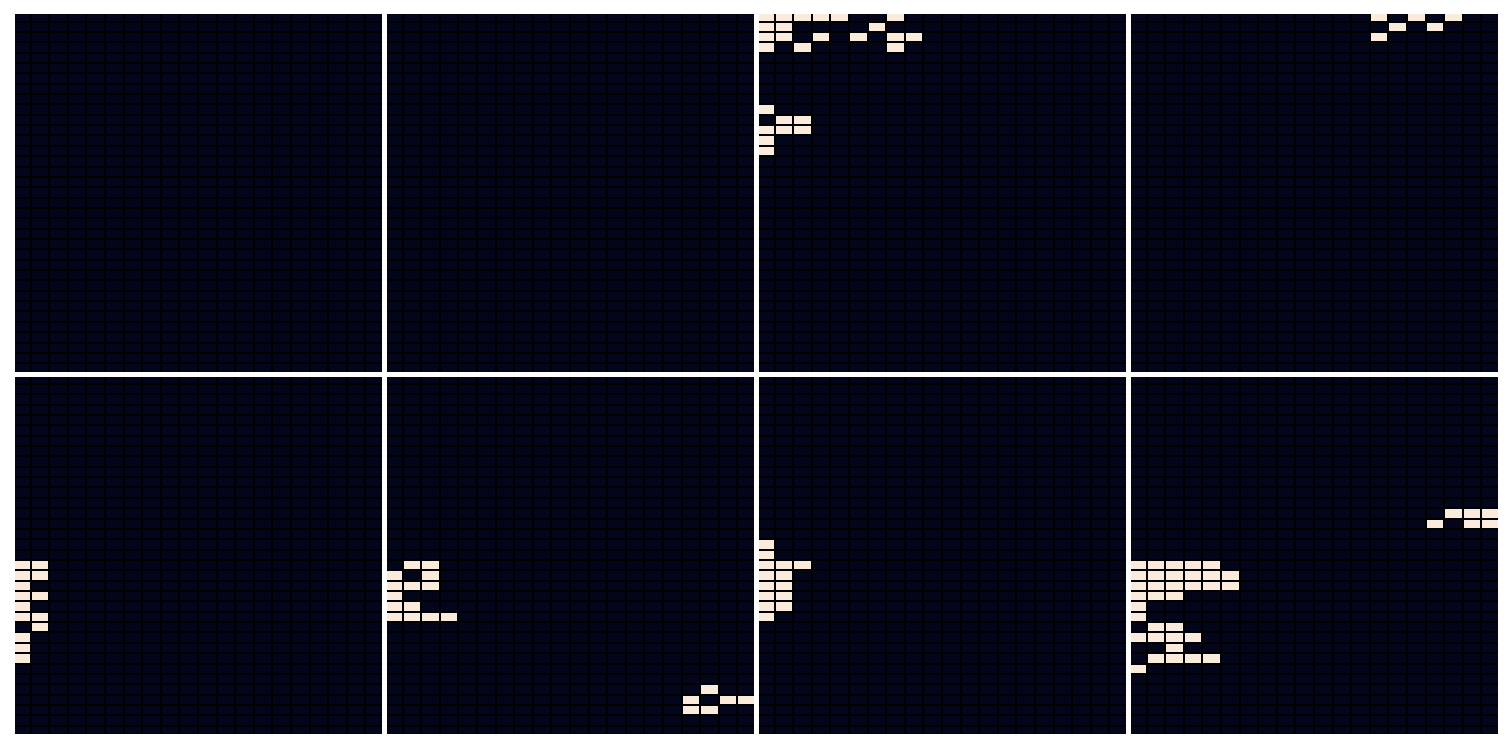

<Figure size 432x288 with 0 Axes>

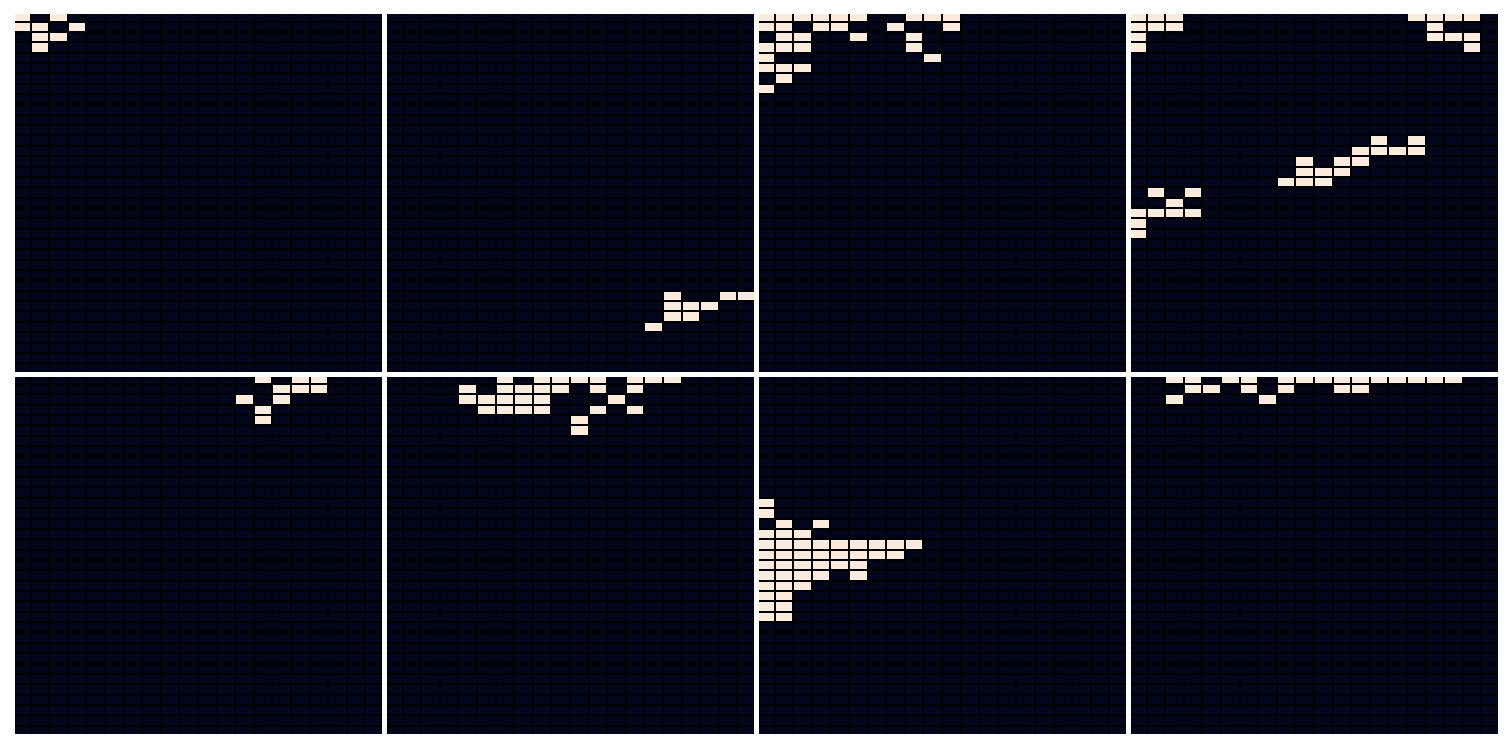

<Figure size 432x288 with 0 Axes>

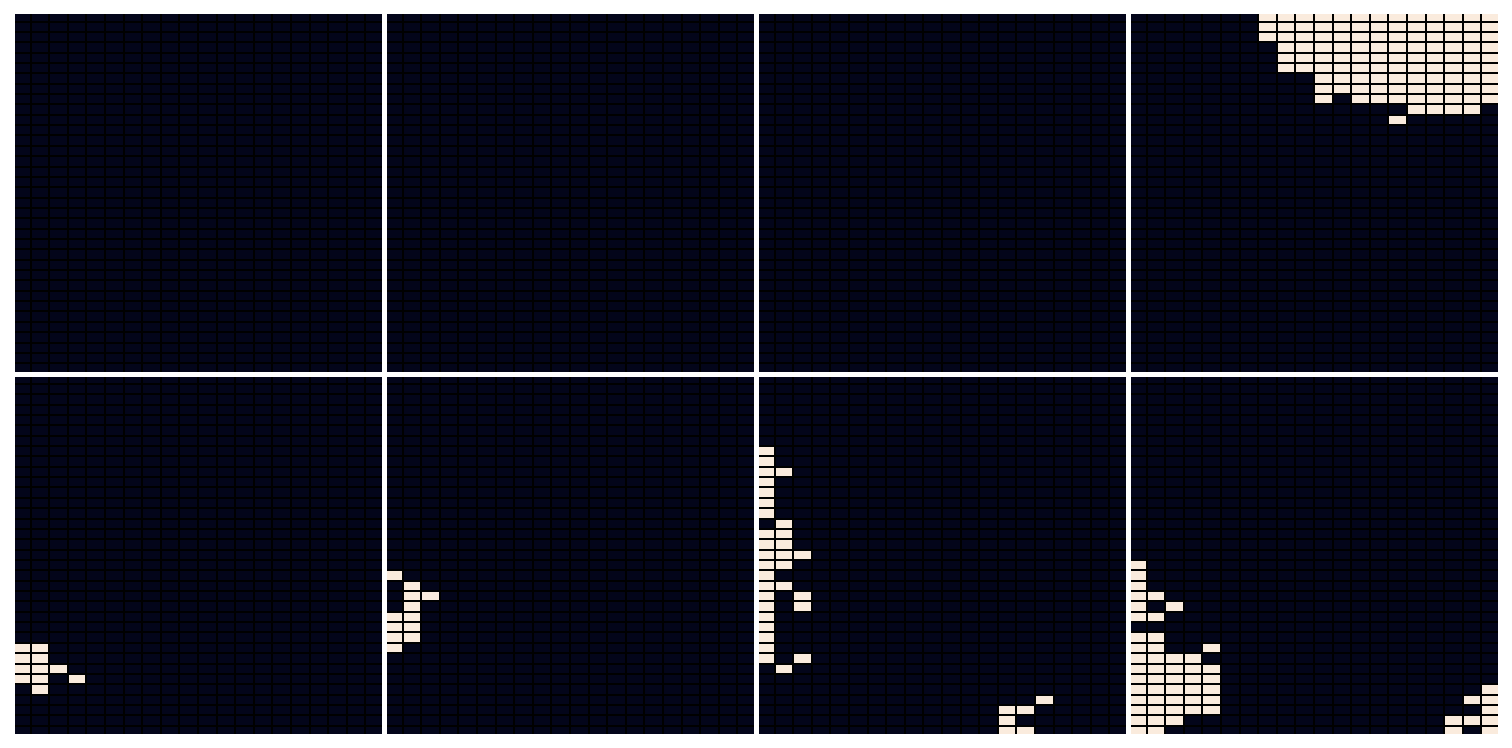

<Figure size 432x288 with 0 Axes>

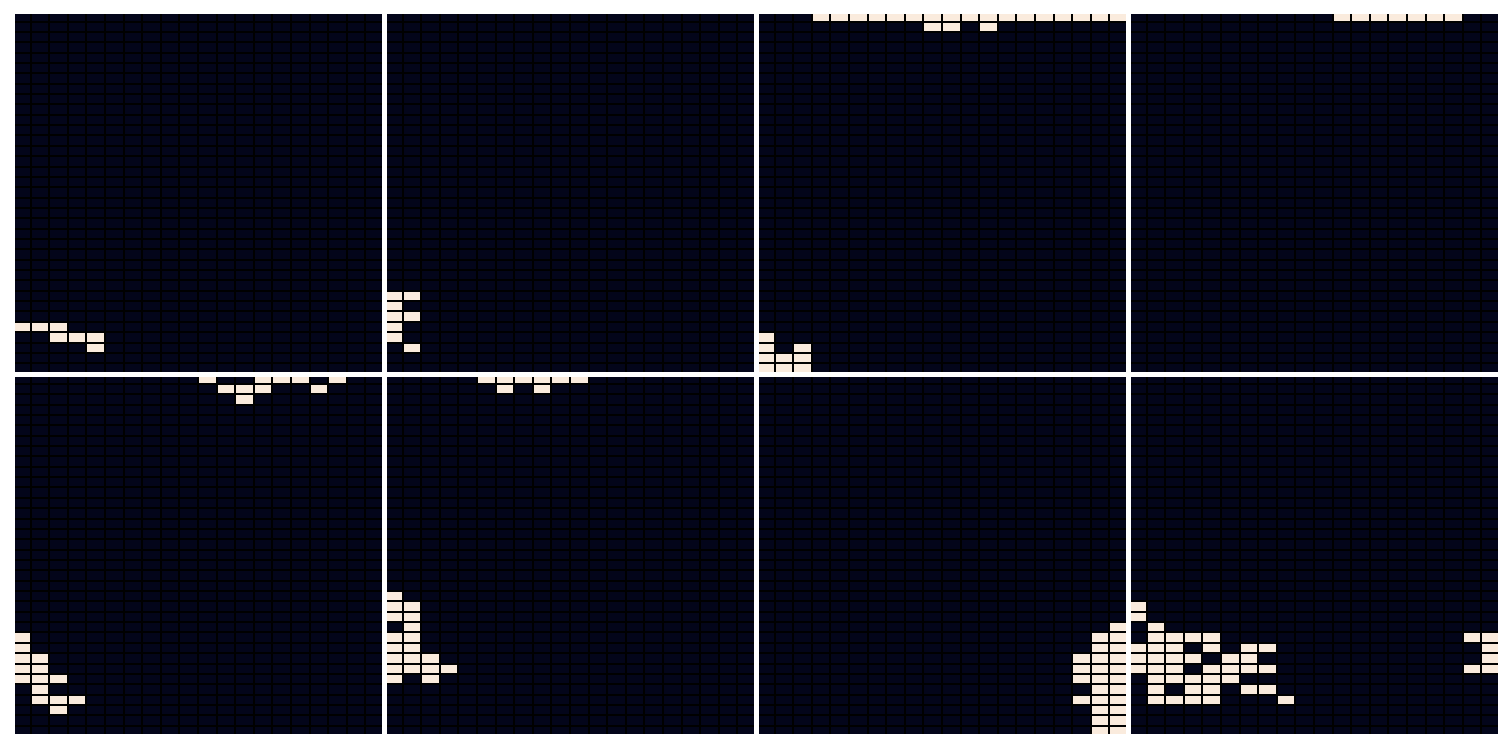

<Figure size 432x288 with 0 Axes>

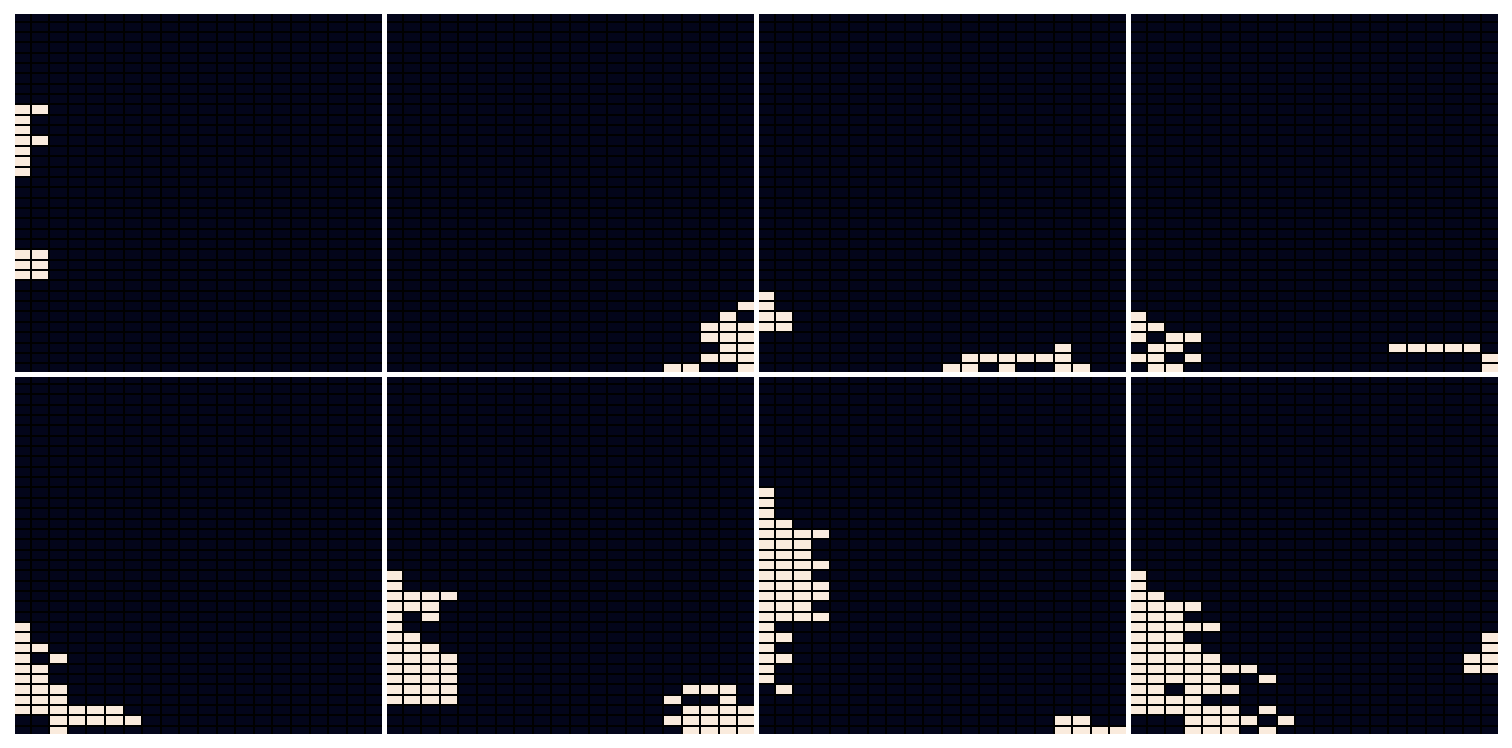

<Figure size 432x288 with 0 Axes>

In [21]:
count_mask = connected_components_analysis("count")

If we layer these masks atop one another, we see an interesting spatial pattern: these regions of low cell count appear to concentrate most heavily in regions around the edges and corners of the wells.

<Figure size 432x288 with 0 Axes>

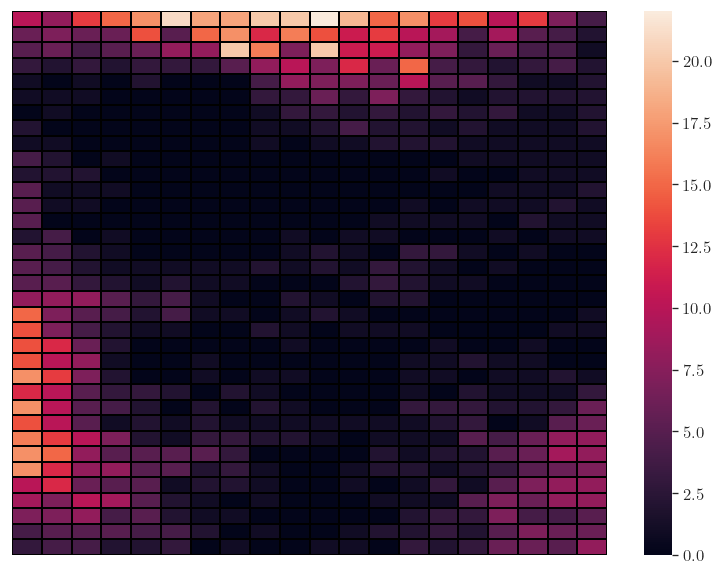

In [22]:
plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=120)
sns.heatmap(
    count_mask, ax=ax, linewidths=1, 
    linecolor='black', xticklabels=False, yticklabels=False, 
)
plt.show()

We repeat this analysis on the nuclear area to demonstrate a similar spatial coherence is also apparent there.

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

<Figure size 1920x960 with 0 Axes>

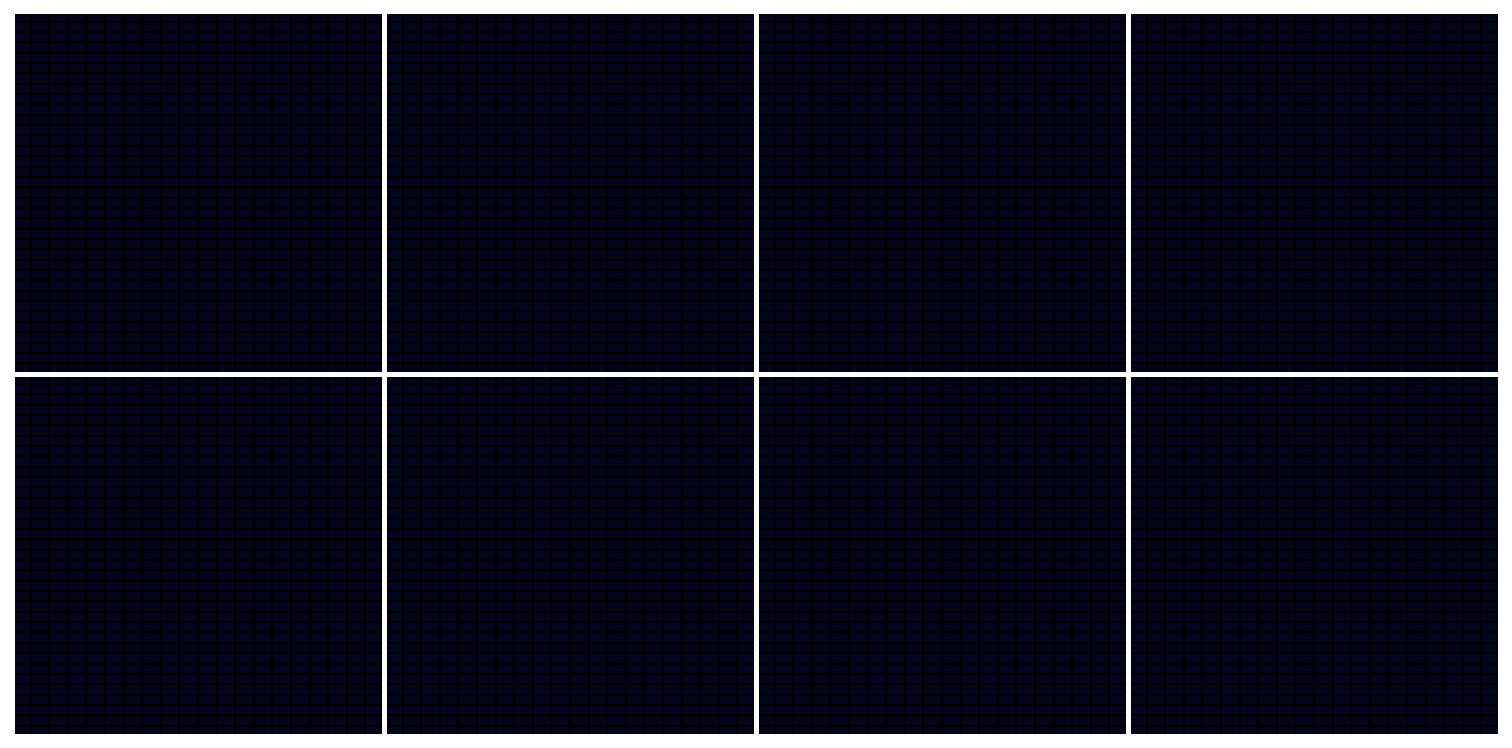

<Figure size 432x288 with 0 Axes>

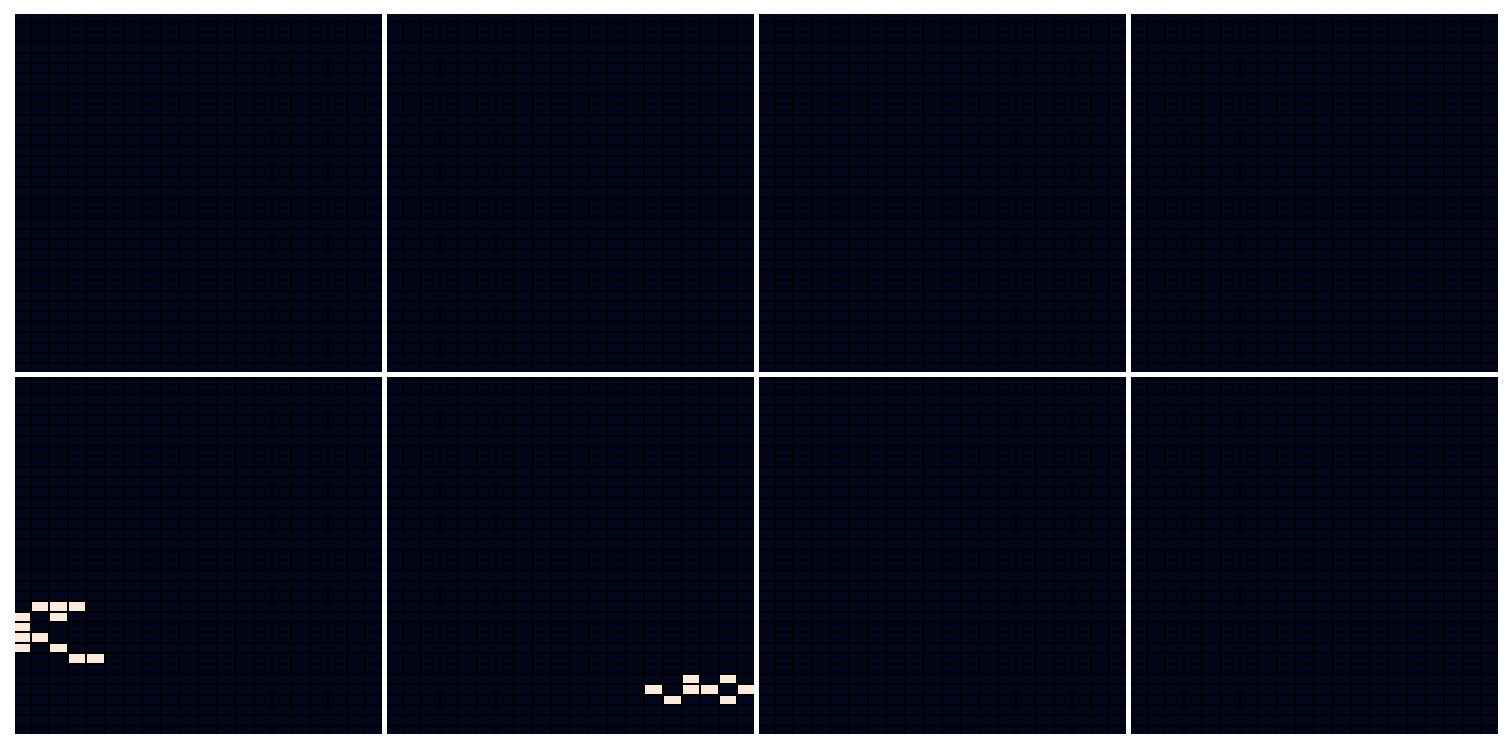

<Figure size 432x288 with 0 Axes>

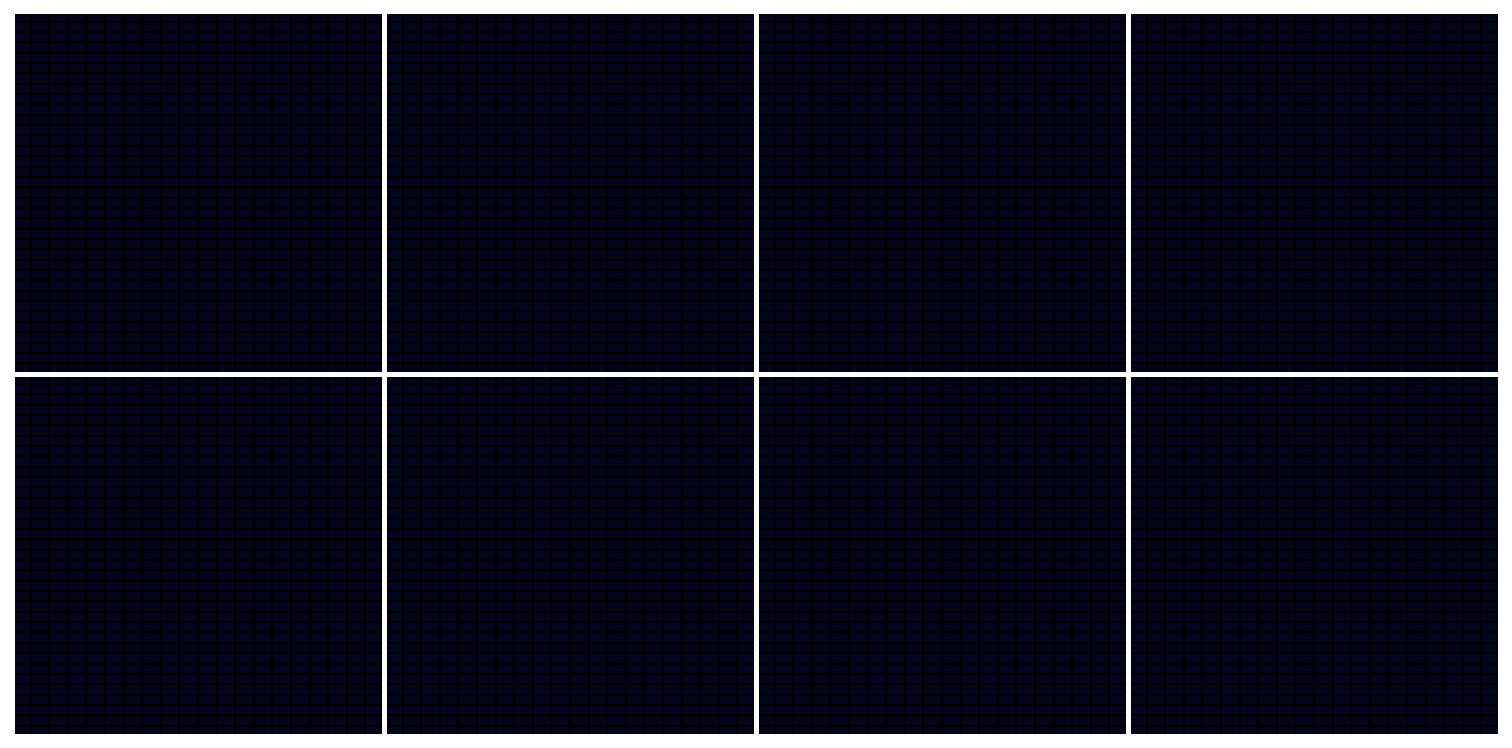

<Figure size 432x288 with 0 Axes>

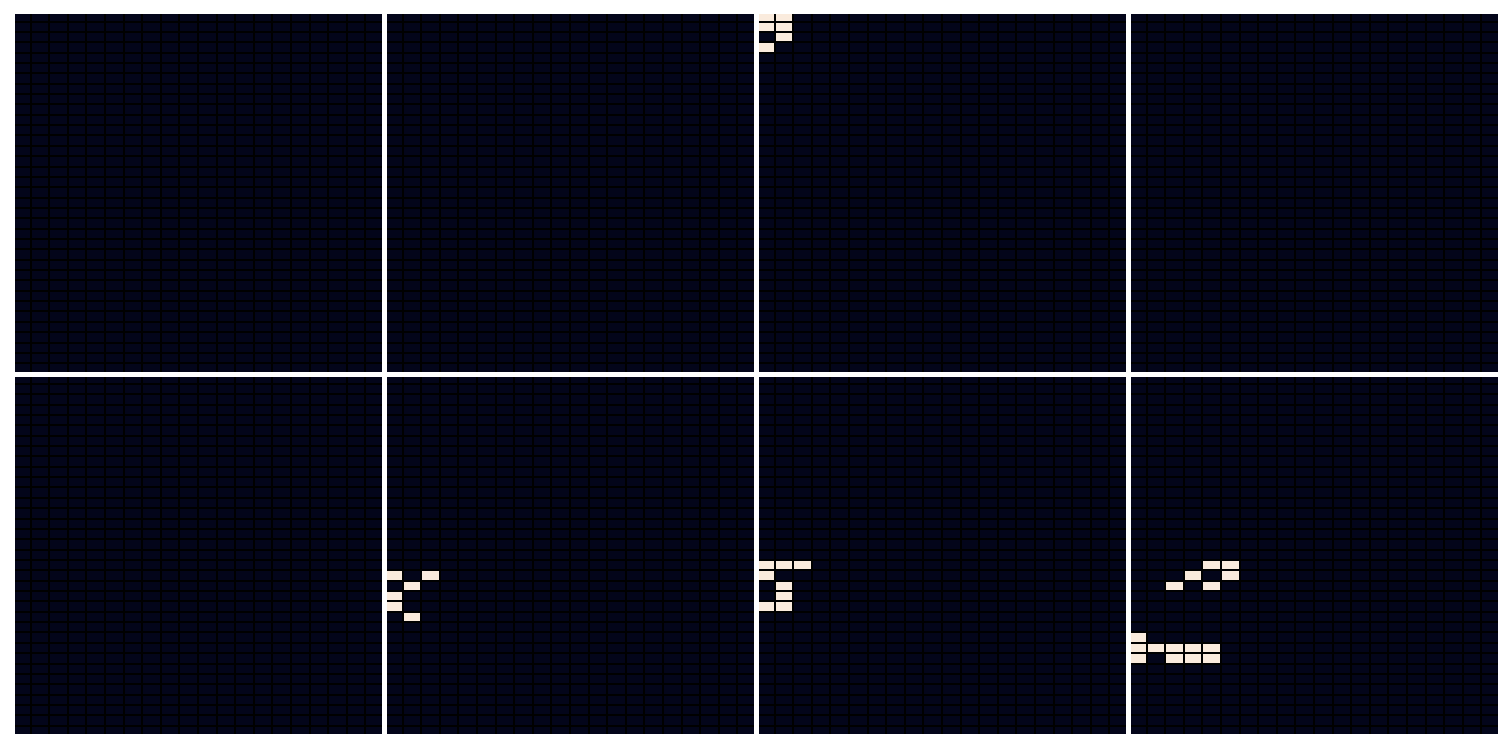

<Figure size 432x288 with 0 Axes>

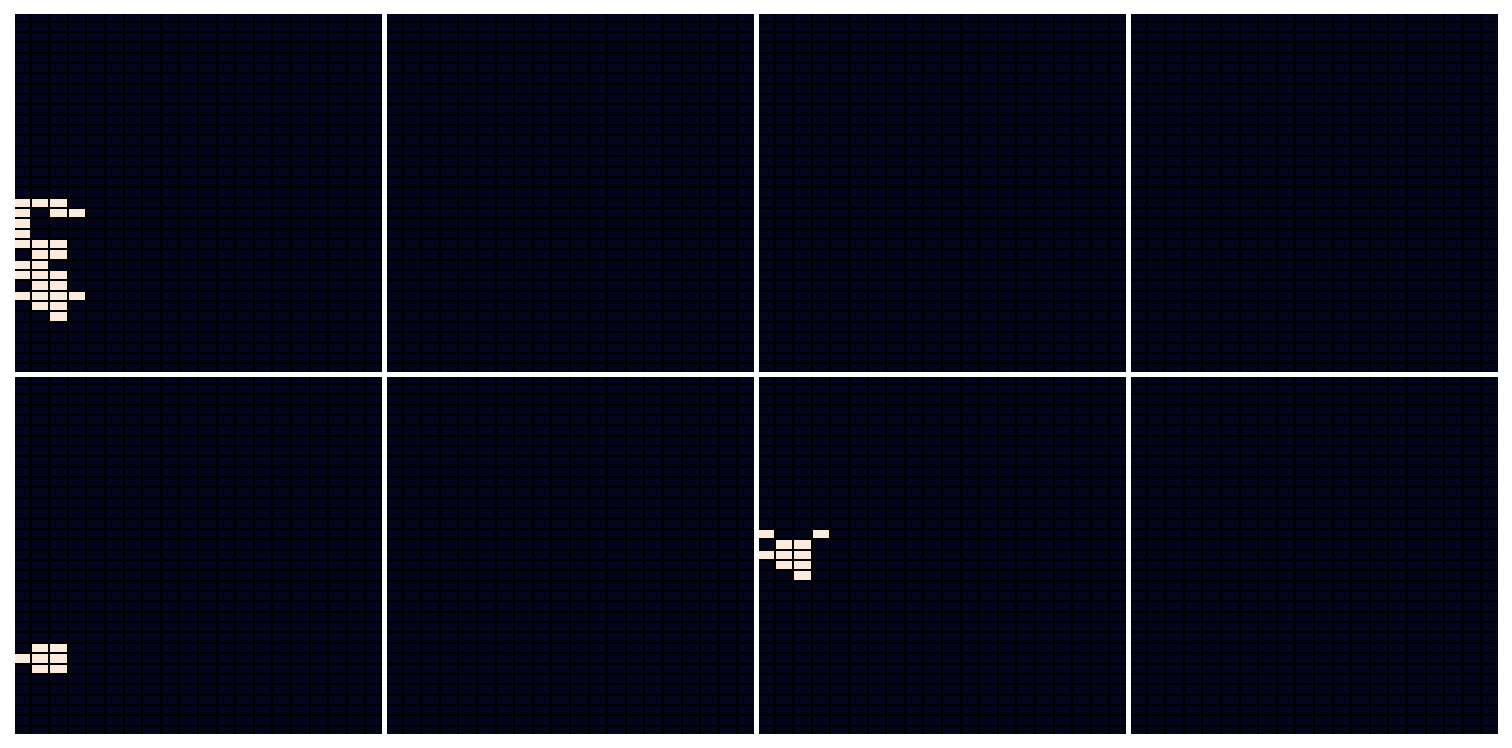

<Figure size 432x288 with 0 Axes>

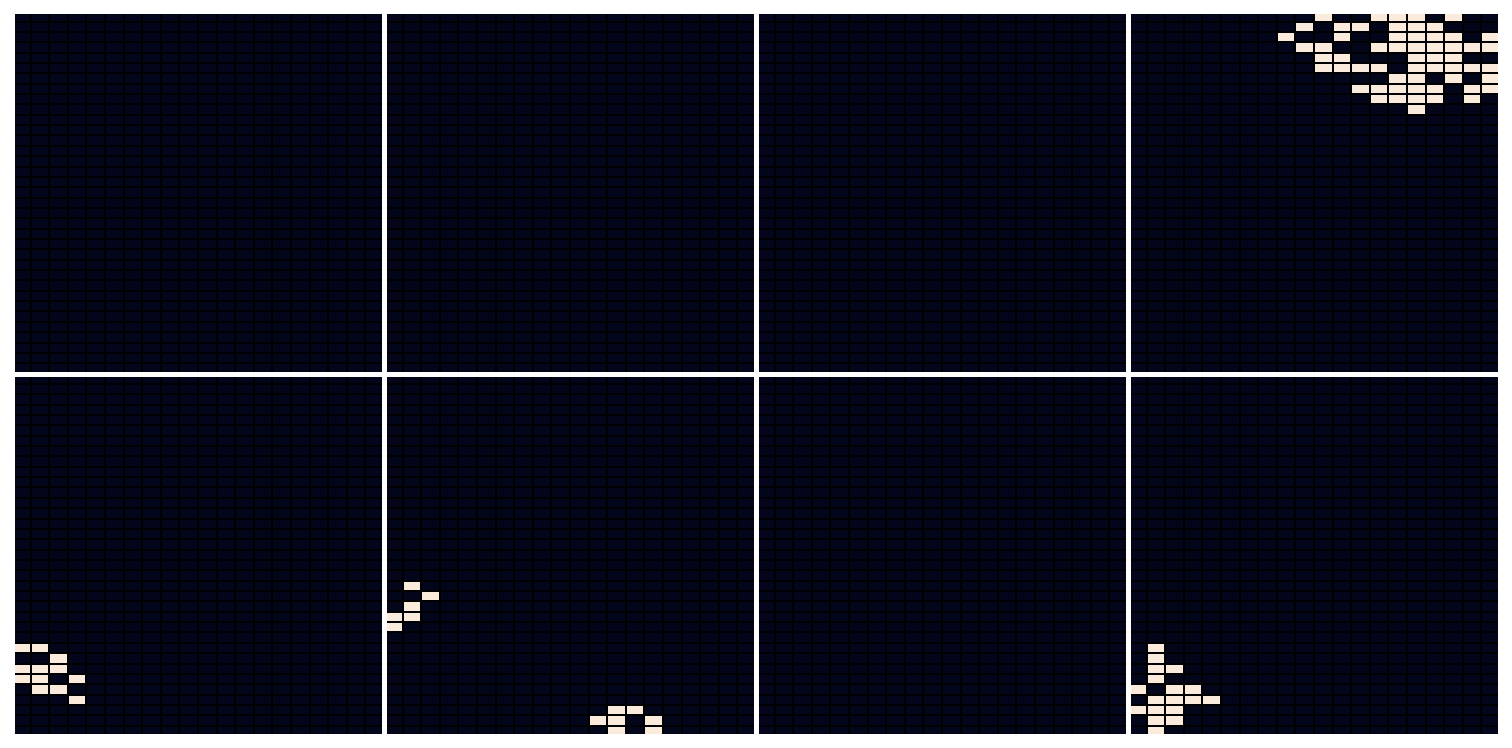

<Figure size 432x288 with 0 Axes>

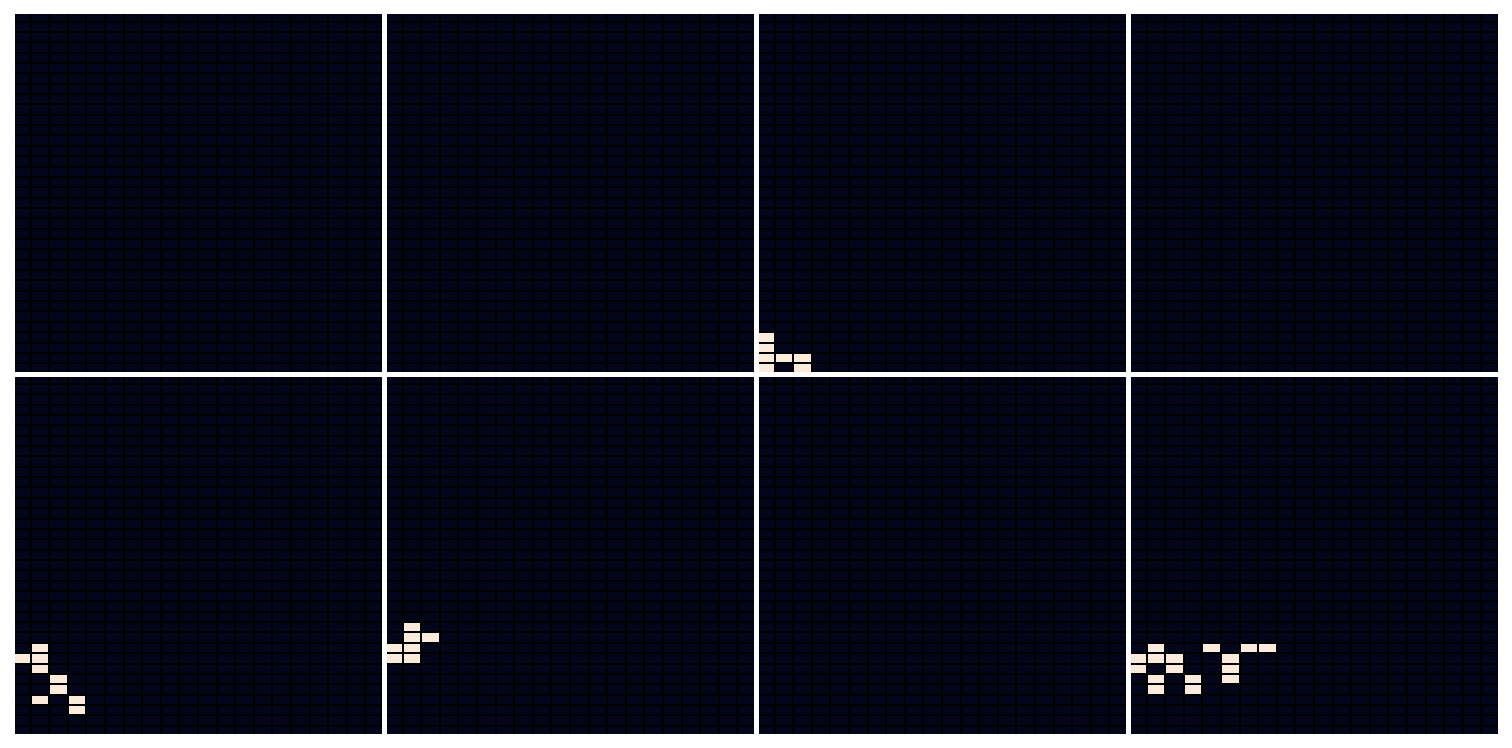

<Figure size 432x288 with 0 Axes>

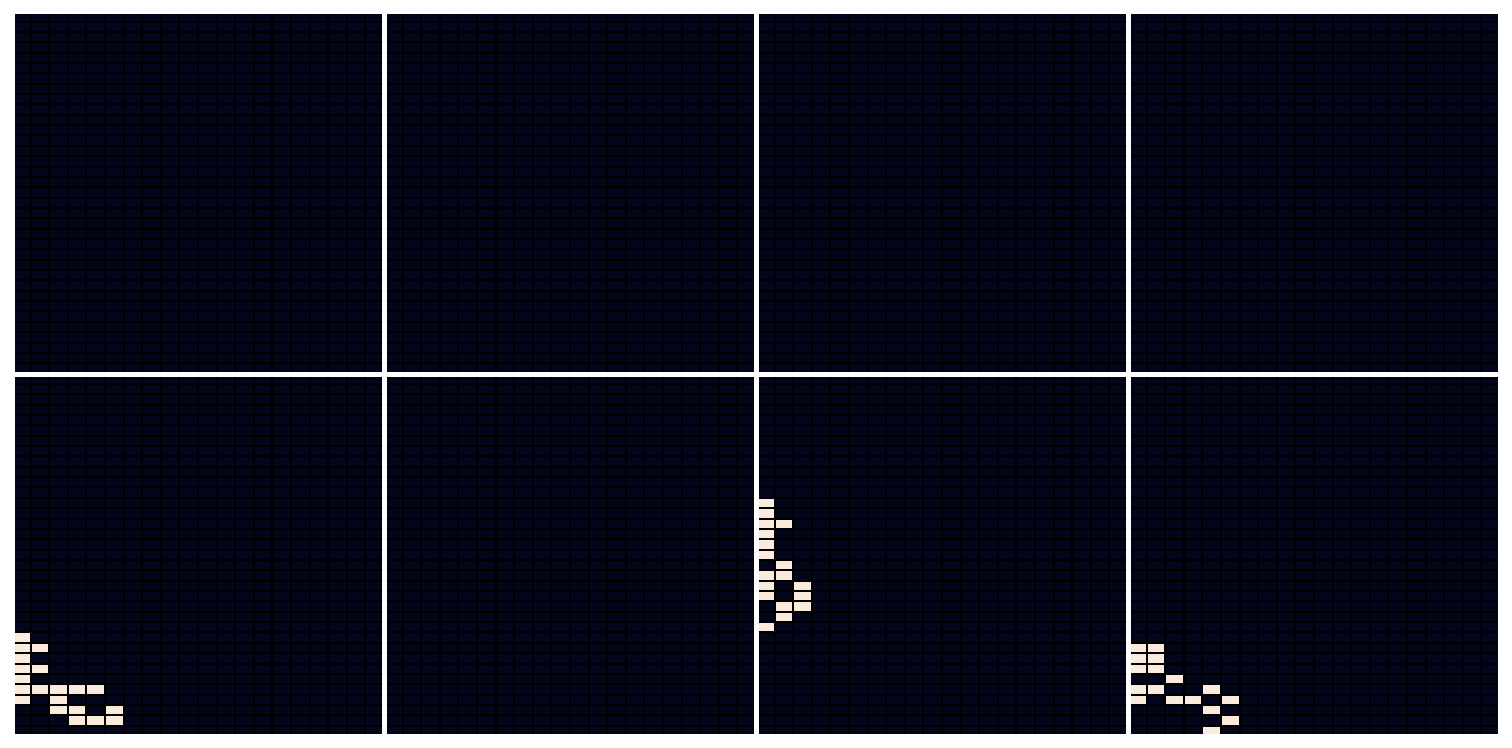

<Figure size 432x288 with 0 Axes>

In [25]:
nuclear_area_mask = connected_components_analysis("nuclear_area")

<Figure size 432x288 with 0 Axes>

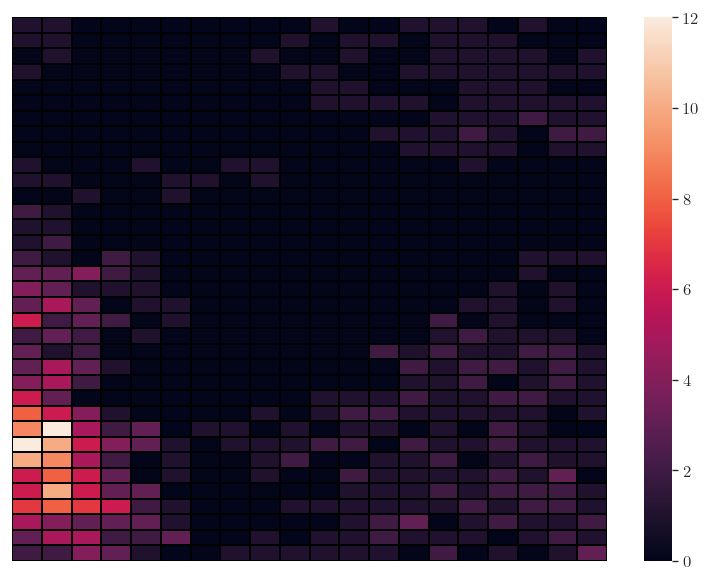

In [26]:
plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=120)
sns.heatmap(
    nuclear_area_mask, ax=ax, linewidths=1, 
    linecolor='black', xticklabels=False, yticklabels=False, 
)
plt.show()

### Splotch Analysis Takeaway
Observing the spatial coherence of these data when such structure is unexpected, we recommend investigating the experimental setup to determine if there were potential issues with the apparatus or in the collection procedure. Downstream analysis is sullied as a result of the presence of such seeming experimental error, from which incorrect conclusions may be drawn. While discarding such regions of the data is a naive way to patch this issue, it suffers from the clear drawback of throwing away what should be valid data, further reducing sample sizes for assessing significances of ECMP/ligand interactions.